### In this notebook we perform federated learning

In federated learning each base station has access only to it's private dataset, however they collaborate together to train a model that has satifactory results on data from any other base station.

In [1]:
import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))

In [2]:
import copy

import random

from collections import OrderedDict
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from argparse import Namespace

In [3]:
from ml.utils.data_utils import read_data, generate_time_lags, time_to_feature, handle_nans, to_Xy, \
    to_torch_dataset, to_timeseries_rep, assign_statistics, \
    to_train_val, scale_features, get_data_by_area, remove_identifiers, get_exogenous_data_by_area, handle_outliers

In [4]:
from ml.utils.train_utils import train, test

In [5]:
from ml.models.mlp import MLP
from ml.models.rnn import RNN
from ml.models.lstm import LSTM
from ml.models.gru import GRU
from ml.models.cnn import CNN
from ml.models.rnn_autoencoder import DualAttentionAutoEncoder

In [6]:
from ml.fl.defaults import create_regression_client
from ml.fl.client_proxy import SimpleClientProxy
from ml.fl.server.server import Server
from ml.utils.helpers import accumulate_metric

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("current used device:", device)


current used device: mps


In [8]:
args = Namespace(
    data_path='../dataset/kmeans++_cluster_split/cluster_0.csv', # dataset
    data_path_test=None , # test dataset
    test_size=0.2, # validation size
    targets=['power_output'], # the target columns
    num_lags= 24, # the number of past observations to feed as input

    identifier='GSRN', # the column name that identifies a bs

    nan_constant=0, # the constant to transform nan values
    x_scaler='minmax', # x_scaler
    y_scaler='minmax', # y_scaler
    outlier_detection=None, # whether to perform flooring and capping

    
    criterion='mse', # optimization criterion, mse or l1
    fl_rounds=10, # the number of federated rounds
    fraction=1., # the percentage of available client to consider for random selection
    aggregation="fedavg", # federated aggregation algorithm
    epochs=3, # the number of maximum local epochs
    lr=0.001, # learning rate
    optimizer='adam', # the optimizer, it can be sgd or adam
    batch_size=128, # the batch size to use
    local_early_stopping=False, # whether to use early stopping
    local_patience=50, # patience value for the early stopping parameter (if specified)
    max_grad_norm=0.0, # whether to clip grad norm
    reg1=0.0, # l1 regularization
    reg2=0.0, # l2 regularization

    cuda=True, # whether to use gpu
    
    seed=0, # reproducibility

    assign_stats=None, # whether to use statistics as exogenous data, ["mean", "median", "std", "variance", "kurtosis", "skew"]
    use_time_features=False, # whether to use datetime features
    
    forecast_horizon = 3 # forecast horizon
)

In [9]:
print(f"Script arguments: {args}\n")

Script arguments: Namespace(data_path='../dataset/kmeans++_cluster_split/cluster_0.csv', data_path_test=None, test_size=0.2, targets=['power_output'], num_lags=24, identifier='GSRN', nan_constant=0, x_scaler='minmax', y_scaler='minmax', outlier_detection=None, criterion='mse', fl_rounds=10, fraction=1.0, aggregation='fedavg', epochs=3, lr=0.001, optimizer='adam', batch_size=128, local_early_stopping=False, local_patience=50, max_grad_norm=0.0, reg1=0.0, reg2=0.0, cuda=True, seed=0, assign_stats=None, use_time_features=False, forecast_horizon=3)



In [11]:
def seed_all():
    # ensure reproducibility
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [12]:
seed_all()

### The pre-processing method is almost equivalent to centralized learning. The only difference is that the scaling operations are performed individually on each base station. In contrast, in centralized learning the scaling is performed by considering the combined data from all base stations.

In [13]:
def make_preprocessing():
    """Preprocess a given .csv"""
    # read data
    df = read_data(args.data_path)
    # handle nans
    df = handle_nans(train_data=df, constant=args.nan_constant,
                     identifier=args.identifier)
    # split to train/validation
    train_data, val_data = to_train_val(df)
    
    # handle outliers (if specified) not used here since we dont want to remove any data
    if args.outlier_detection is not None:
        train_data = handle_outliers(df=train_data, columns=args.outlier_columns,
                                     identifier=args.identifier, kwargs=args.outlier_kwargs)
    
    # get X and y
    X_train, X_val, y_train, y_val = to_Xy(train_data=train_data, val_data=val_data,
                                          targets=args.targets,ignore_cols=["cluster"])
    
    # === Step 1: Extract static feature columns immediately after splitting (before lagging) ===
    static_columns = ["age", "Capacity_kw"]
    static_train_raw = X_train[static_columns].copy()
    static_val_raw = X_val[static_columns].copy()
    
    # scale X
    X_train, X_val, x_scalers = scale_features(train_data=X_train, val_data=X_val,
                                              scaler=args.x_scaler,
                                              per_area=True, # the features are scaled locally
                                              identifier=args.identifier)
    
    # scale y
    y_train, y_val, y_scalers = scale_features(train_data=y_train, val_data=y_val,
                                              scaler=args.y_scaler, 
                                              per_area=True,
                                              identifier=args.identifier)
    
    # === Step 3: Re-attach the unscaled static feature columns (to prevent them from being zeroed by scaling) ===
    for col in static_columns:
        X_train[col] = static_train_raw[col]
        X_val[col] = static_val_raw[col]
    
       # generate time lags
    X_train = generate_time_lags(X_train, args.num_lags)
    X_val = generate_time_lags(X_val, args.num_lags)
    y_train = generate_time_lags(y_train, args.num_lags, is_y=True)
    y_val = generate_time_lags(y_val, args.num_lags, is_y=True)

    # === Step 5:Perform global MinMax scaling on the static feature columns after lag===
    static_lagged_cols = [col for col in X_train.columns if any(sc in col for sc in static_columns)]

    static_scaler = MinMaxScaler()
    X_train[static_lagged_cols] = static_scaler.fit_transform(X_train[static_lagged_cols])
    X_val[static_lagged_cols] = static_scaler.transform(X_val[static_lagged_cols])

    # === Step X: multi-step forecasting target construction ===
    forecast_horizon = args.forecast_horizon  # predict future 3 hours
    multi_y_train = []
    multi_y_val = []
    aligned_X_train = []
    aligned_X_val = []

    # Process the training set separately for each turbine
    for gsrn, group in y_train.groupby("GSRN"):
        group_multi = pd.DataFrame(index=group.index)  # don't keep original columns, only create new ones
        for step in range(1, forecast_horizon + 1):
            for col in args.targets:
                group_multi[f"{col}_t+{step}"] = group[col].shift(-step)

        # Remove rows with NaN values
        group_multi = group_multi.iloc[:-forecast_horizon]
        group_multi["GSRN"] = gsrn 
        multi_y_train.append(group_multi)

        # The X_train is truncated accordingly
        group_X = X_train[X_train["GSRN"] == gsrn].iloc[:-forecast_horizon]
        aligned_X_train.append(group_X)

    # Process the validation set separately for each turbine
    for gsrn, group in y_val.groupby("GSRN"):
        group_multi = pd.DataFrame(index=group.index)
        for step in range(1, forecast_horizon + 1):
            for col in args.targets:
                group_multi[f"{col}_t+{step}"] = group[col].shift(-step)

        group_multi = group_multi.iloc[:-forecast_horizon]
        group_multi["GSRN"] = gsrn
        multi_y_val.append(group_multi)

        group_X = X_val[X_val["GSRN"] == gsrn].iloc[:-forecast_horizon]
        aligned_X_val.append(group_X)

    # Concatenate results from all turbines
    y_train = pd.concat(multi_y_train, axis=0)
    y_val = pd.concat(multi_y_val, axis=0)
    X_train = pd.concat(aligned_X_train, axis=0)
    X_val = pd.concat(aligned_X_val, axis=0)

    # Select only the target columns (excluding the original power_output)
    target_cols = [f"{col}_t+{step}" for col in args.targets for step in range(1, forecast_horizon + 1)]
    y_train = y_train[target_cols + ["GSRN"]]
    y_val = y_val[target_cols + ["GSRN"]]


    ## the following exogenous data processing is not used ##

    # get datetime features as exogenous data
    date_time_df_train = time_to_feature(
        X_train, args.use_time_features, identifier=args.identifier
    )
    date_time_df_val = time_to_feature(
        X_val, args.use_time_features, identifier=args.identifier
    )
    
    # get statistics as exogenous data
    stats_df_train = assign_statistics(X_train, args.assign_stats, args.num_lags,
                                       targets=args.targets, identifier=args.identifier)
    stats_df_val = assign_statistics(X_val, args.assign_stats, args.num_lags, 
                                       targets=args.targets, identifier=args.identifier)
    
    # concat the exogenous features (if any) to a single dataframe
    if date_time_df_train is not None or stats_df_train is not None:
        exogenous_data_train = pd.concat([date_time_df_train, stats_df_train], axis=1)
        # remove duplicate columns (if any)
        exogenous_data_train = exogenous_data_train.loc[:, ~exogenous_data_train.columns.duplicated()].copy()
        assert len(exogenous_data_train) == len(X_train) == len(y_train)
    else:
        exogenous_data_train = None
    if date_time_df_val is not None or stats_df_val is not None:
        exogenous_data_val = pd.concat([date_time_df_val, stats_df_val], axis=1)
        exogenous_data_val = exogenous_data_val.loc[:, ~exogenous_data_val.columns.duplicated()].copy()
        assert len(exogenous_data_val) == len(X_val) == len(y_val)
    else:
        exogenous_data_val = None

    return X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers

In [14]:
X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers= make_preprocessing()

/Users/libowen/Library/Python/3.10/lib/python/site-packages/sklearn/impute/_base.py:590: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
INFO logger 2025-11-13 16:18:33,782 | data_utils.py:393 | Observations info in 570715000000128905
INFO logger 2025-11-13 16:18:33,783 | data_utils.py:394 | 	Total number of samples:  8760
INFO logger 2025-11-13 16:18:33,784 | data_utils.py:395 | 	Number of samples for training: 7008
INFO logger 2025-11-13 16:18:33,784 | data_utils.py:396 | 	Number of samples for validation:  1752
INFO logger 2025-11-13 16:18:33,787 | data_utils.py:393 | Observations info in 570715000000088643
INFO logger 2025-11-13 16:18:33,788 | data_utils.py:394 | 	Total number of samples:  8760
INFO logger 2025-11-13 16:18:33,788 | data_utils.py:395 | 	Number of samples for training: 7008
INFO logg

In [15]:
X_train.head()


Cluster_lag-24  Capacity_kw_lag-24  power_output_lag-24  \
time                                                                           
2019-01-02 00:00:00             0.0              0.1875             0.962544   
2019-01-02 01:00:00             0.0              0.1875             0.996595   
2019-01-02 02:00:00             0.0              0.1875             0.999520   
2019-01-02 03:00:00             0.0              0.1875             0.999651   
2019-01-02 04:00:00             0.0              0.1875             0.999345   

                     age_lag-24  wind_dir_cos_lag-24  wind_dir_sin_lag-24  \
time                                                                        
2019-01-02 00:00:00         1.0              0.33720              0.02725   
2019-01-02 01:00:00         1.0              0.30465              0.03975   
2019-01-02 02:00:00         1.0              0.32080              0.03320   
2019-01-02 03:00:00         1.0              0.35380              0.02185   
2019-01-02 04:00:00         1.0              0.38750              0.01280   

                     hour_cos_lag-24  hour_sin_lag-24  temperature_c_lag-24  \
time                                                                          
2019-01-02 00:00:00          1.00000          0.50000              0.333333   
2019-01-02 01:00:00          0.98295          0.62940              0.327684   
2019-01-02 02:00:00          0.93300          0.75000              0.327684   
2019-01-02 03:00:00          0.85355          0.85355              0.333333   
2019-01-02 04:00:00          0.75000          0.93300              0.347458   

                     wind_speed_lag-24  ...  Capacity_kw_lag-1  \
time                                    ...                      
2019-01-02 00:00:00           0.632743  ...             0.1875   
2019-01-02 01:00:00           0.641593  ...             0.1875   
2019-01-02 02:00:00           0.659292  ...             0.1875   
2019-01-02 03:00:00           0.694690  ...             0.1875   
2019-01-02 04:00:00           0.787611  ...             0.1875   

                     power_output_lag-1  age_lag-1  wind_dir_cos_lag-1  \
time                                                                     
2019-01-02 00:00:00            0.998341        1.0             0.98515   
2019-01-02 01:00:00            0.802855        1.0             0.99240   
2019-01-02 02:00:00            0.410486        1.0             0.99625   
2019-01-02 03:00:00            0.998254        1.0             0.99725   
2019-01-02 04:00:00            0.996115        1.0             0.99930   

                     wind_dir_sin_lag-1  hour_cos_lag-1  hour_sin_lag-1  \
time                                                                      
2019-01-02 00:00:00             0.37905         0.98295         0.37060   
2019-01-02 01:00:00             0.41320         1.00000         0.50000   
2019-01-02 02:00:00             0.43905         0.98295         0.62940   
2019-01-02 03:00:00             0.44775         0.93300         0.75000   
2019-01-02 04:00:00             0.47385         0.85355         0.85355   

                     temperature_c_lag-1  wind_speed_lag-1                GSRN  
time                                                                            
2019-01-02 00:00:00             0.257062          0.946903  570715000000084607  
2019-01-02 01:00:00             0.245763          0.973451  570715000000084607  
2019-01-02 02:00:00             0.237288          0.964602  570715000000084607  
2019-01-02 03:00:00             0.225989          0.938053  570715000000084607  
2019-01-02 04:00:00             0.214689          0.884956  570715000000084607  

[5 rows x 241 columns]

In [16]:
y_train.head()

power_output_t+1  power_output_t+2  power_output_t+3  \
time                                                                        
2019-01-02 00:00:00          0.410486          0.998254          0.996115   
2019-01-02 01:00:00          0.998254          0.996115          0.998734   
2019-01-02 02:00:00          0.996115          0.998734          0.997555   
2019-01-02 03:00:00          0.998734          0.997555          0.998865   
2019-01-02 04:00:00          0.997555          0.998865          0.997774   

                                   GSRN  
time                                     
2019-01-02 00:00:00  570715000000084607  
2019-01-02 01:00:00  570715000000084607  
2019-01-02 02:00:00  570715000000084607  
2019-01-02 03:00:00  570715000000084607  
2019-01-02 04:00:00  570715000000084607

In [17]:
X_val.head()

Cluster_lag-24  Capacity_kw_lag-24  power_output_lag-24  \
time                                                                           
2019-10-21 00:00:00             0.0              0.1875             0.155542   
2019-10-21 01:00:00             0.0              0.1875             0.082988   
2019-10-21 02:00:00             0.0              0.1875             0.091893   
2019-10-21 03:00:00             0.0              0.1875             0.082857   
2019-10-21 04:00:00             0.0              0.1875             0.126075   

                     age_lag-24  wind_dir_cos_lag-24  wind_dir_sin_lag-24  \
time                                                                        
2019-10-21 00:00:00         1.0              0.03015               0.6710   
2019-10-21 01:00:00         1.0              0.00920               0.4046   
2019-10-21 02:00:00         1.0              0.01705               0.3706   
2019-10-21 03:00:00         1.0              0.11700               0.1786   
2019-10-21 04:00:00         1.0              0.08550               0.2204   

                     hour_cos_lag-24  hour_sin_lag-24  temperature_c_lag-24  \
time                                                                          
2019-10-21 00:00:00          1.00000          0.50000              0.471751   
2019-10-21 01:00:00          0.98295          0.62940              0.491525   
2019-10-21 02:00:00          0.93300          0.75000              0.488701   
2019-10-21 03:00:00          0.85355          0.85355              0.485876   
2019-10-21 04:00:00          0.75000          0.93300              0.477401   

                     wind_speed_lag-24  ...  Capacity_kw_lag-1  \
time                                    ...                      
2019-10-21 00:00:00           0.415929  ...             0.1875   
2019-10-21 01:00:00           0.362832  ...             0.1875   
2019-10-21 02:00:00           0.362832  ...             0.1875   
2019-10-21 03:00:00           0.309735  ...             0.1875   
2019-10-21 04:00:00           0.327434  ...             0.1875   

                     power_output_lag-1  age_lag-1  wind_dir_cos_lag-1  \
time                                                                     
2019-10-21 00:00:00            0.000000        1.0             0.10070   
2019-10-21 01:00:00            0.000437        1.0             0.96985   
2019-10-21 02:00:00            0.000829        1.0             0.64620   
2019-10-21 03:00:00            0.012485        1.0             0.56095   
2019-10-21 04:00:00            0.037019        1.0             0.54360   

                     wind_dir_sin_lag-1  hour_cos_lag-1  hour_sin_lag-1  \
time                                                                      
2019-10-21 00:00:00             0.19910         0.98295         0.37060   
2019-10-21 01:00:00             0.67100         1.00000         0.50000   
2019-10-21 02:00:00             0.97815         0.98295         0.62940   
2019-10-21 03:00:00             0.99625         0.93300         0.75000   
2019-10-21 04:00:00             0.99810         0.85355         0.85355   

                     temperature_c_lag-1  wind_speed_lag-1                GSRN  
time                                                                            
2019-10-21 00:00:00             0.480226          0.013274  570715000000084607  
2019-10-21 01:00:00             0.474576          0.008850  570715000000084607  
2019-10-21 02:00:00             0.480226          0.221239  570715000000084607  
2019-10-21 03:00:00             0.477401          0.252212  570715000000084607  
2019-10-21 04:00:00             0.474576          0.252212  570715000000084607  

[5 rows x 241 columns]

In [18]:
y_val.head()

power_output_t+1  power_output_t+2  power_output_t+3  \
time                                                                        
2019-10-21 00:00:00          0.000829          0.012485          0.037019   
2019-10-21 01:00:00          0.012485          0.037019          0.076396   
2019-10-21 02:00:00          0.037019          0.076396          0.022046   
2019-10-21 03:00:00          0.076396          0.022046          0.125857   
2019-10-21 04:00:00          0.022046          0.125857          0.102021   

                                   GSRN  
time                                     
2019-10-21 00:00:00  570715000000084607  
2019-10-21 01:00:00  570715000000084607  
2019-10-21 02:00:00  570715000000084607  
2019-10-21 03:00:00  570715000000084607  
2019-10-21 04:00:00  570715000000084607

In [19]:
power_output_lag_indices = [
    i for i, col in enumerate(X_train.columns)
    if col.startswith("power_output_lag")
]
print("power_output_lag is in these column indices:", power_output_lag_indices)

power_output_lag is in these column indices: [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232]


In [20]:
y_train.head()

power_output_t+1  power_output_t+2  power_output_t+3  \
time                                                                        
2019-01-02 00:00:00          0.410486          0.998254          0.996115   
2019-01-02 01:00:00          0.998254          0.996115          0.998734   
2019-01-02 02:00:00          0.996115          0.998734          0.997555   
2019-01-02 03:00:00          0.998734          0.997555          0.998865   
2019-01-02 04:00:00          0.997555          0.998865          0.997774   

                                   GSRN  
time                                     
2019-01-02 00:00:00  570715000000084607  
2019-01-02 01:00:00  570715000000084607  
2019-01-02 02:00:00  570715000000084607  
2019-01-02 03:00:00  570715000000084607  
2019-01-02 04:00:00  570715000000084607

In [21]:
x_scalers, y_scalers

({np.int64(570715000000128905): MinMaxScaler(),
  np.int64(570715000000088643): MinMaxScaler(),
  np.int64(570715000000088667): MinMaxScaler(),
  np.int64(570715000000125669): MinMaxScaler(),
  np.int64(570715000000125706): MinMaxScaler(),
  np.int64(570715000000125652): MinMaxScaler(),
  np.int64(570715000000125683): MinMaxScaler(),
  np.int64(571313161170169709): MinMaxScaler(),
  np.int64(571313161170169150): MinMaxScaler(),
  np.int64(571313161170169785): MinMaxScaler(),
  np.int64(570715000000125621): MinMaxScaler(),
  np.int64(570715000000125614): MinMaxScaler(),
  np.int64(571313174001641268): MinMaxScaler(),
  np.int64(570715000000125591): MinMaxScaler(),
  np.int64(571313174001641251): MinMaxScaler(),
  np.int64(570715000000125546): MinMaxScaler(),
  np.int64(571313174001641244): MinMaxScaler(),
  np.int64(571313174001641237): MinMaxScaler(),
  np.int64(571313174001641220): MinMaxScaler(),
  np.int64(570715000000084652): MinMaxScaler(),
  np.int64(571313174000780944): MinMaxSc

### Postprocessing in a same manner with centalized learning

In [22]:
def make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers):
    """Make data ready to be fed into ml algorithms"""
    # if there are more than one specified areas, get the data per area
    if X_train[args.identifier].nunique() != 1:
        area_X_train, area_X_val, area_y_train, area_y_val = get_data_by_area(X_train, X_val,
                                                                              y_train, y_val, 
                                                                              identifier=args.identifier)
    else:
        area_X_train, area_X_val, area_y_train, area_y_val = None, None, None, None
    
    client_time_train_index = {}
    client_time_val_index = {}

    for cid in area_y_val:
        # train set time index
        train_index = area_y_train[cid].index.copy()
        valid_train_length = len(area_y_train[cid]) - args.num_lags - args.forecast_horizon
        if valid_train_length <= 0:
            valid_train_length = len(area_y_train[cid])
        client_time_train_index[cid] = train_index[-valid_train_length:]

        # validation set time index
        val_index = area_y_val[cid].index.copy()
        valid_val_length = len(area_y_val[cid]) - args.num_lags - args.forecast_horizon
        if valid_val_length <= 0:
            valid_val_length = len(area_y_val[cid])
        client_time_val_index[cid] = val_index[-valid_val_length:]

    # Get the exogenous data per area.
    if exogenous_data_train is not None:
        exogenous_data_train, exogenous_data_val = get_exogenous_data_by_area(exogenous_data_train,
                                                                              exogenous_data_val)
        
    # transform to np
    if area_X_train is not None:
        for area in area_X_train:
            tmp_X_train, tmp_y_train, tmp_X_val, tmp_y_val = remove_identifiers(
                area_X_train[area], area_y_train[area], area_X_val[area], area_y_val[area])
            tmp_X_train, tmp_y_train = tmp_X_train.to_numpy(), tmp_y_train.to_numpy()
            tmp_X_val, tmp_y_val = tmp_X_val.to_numpy(), tmp_y_val.to_numpy()
            area_X_train[area] = tmp_X_train
            area_X_val[area] = tmp_X_val
            area_y_train[area] = tmp_y_train
            area_y_val[area] = tmp_y_val
    
    if exogenous_data_train is not None:
        for area in exogenous_data_train:
            exogenous_data_train[area] = exogenous_data_train[area].to_numpy()
            exogenous_data_val[area] = exogenous_data_val[area].to_numpy()
    
    # remove identifiers from features, targets
    X_train, y_train, X_val, y_val = remove_identifiers(X_train, y_train, X_val, y_val)
    assert len(X_train.columns) == len(X_val.columns)
    
    num_features = len(X_train.columns) // args.num_lags
    
    # to timeseries representation
    X_train = to_timeseries_rep(X_train.to_numpy(), num_lags=args.num_lags,
                                            num_features=num_features)
    X_val = to_timeseries_rep(X_val.to_numpy(), num_lags=args.num_lags,
                                          num_features=num_features)
    
    if area_X_train is not None:
        area_X_train = to_timeseries_rep(area_X_train, num_lags=args.num_lags,
                                                     num_features=num_features)
        area_X_val = to_timeseries_rep(area_X_val, num_lags=args.num_lags,
                                                   num_features=num_features)
    
    # transform targets to numpy
    y_train, y_val = y_train.to_numpy(), y_val.to_numpy()
    
    print("\n=== Y train shapes by client ===")
    if area_y_train is not None:
        for area, y in area_y_train.items():
            print(f"{area}: {y.shape}")
    print("=== X train shapes by client ===")
    if area_X_train is not None:
        for area, x in area_X_train.items():
            print(f"{area}: {x.shape}")
    print("=== Y val shapes by client ===")
    if area_y_val is not None:
        for area, y in area_y_val.items():
            print(f"{area}: {y.shape}")
    print("=== X val shapes by client ===")
    if area_X_val is not None:
        for area, x in area_X_val.items():
            print(f"{area}: {x.shape}")

    if exogenous_data_train is not None:
        exogenous_data_train_combined, exogenous_data_val_combined = [], []
        for area in exogenous_data_train:
            exogenous_data_train_combined.extend(exogenous_data_train[area])
            exogenous_data_val_combined.extend(exogenous_data_val[area])
        exogenous_data_train_combined = np.stack(exogenous_data_train_combined)
        exogenous_data_val_combined = np.stack(exogenous_data_val_combined)
        exogenous_data_train["all"] = exogenous_data_train_combined
        exogenous_data_val["all"] = exogenous_data_val_combined
    return X_train, X_val, y_train, y_val, area_X_train, area_X_val, area_y_train, area_y_val, exogenous_data_train, exogenous_data_val, client_time_train_index, client_time_val_index

In [23]:
X_train, X_val, y_train, y_val, client_X_train, client_X_val, client_y_train, client_y_val, exogenous_data_train, exogenous_data_val, client_time_train_index, client_time_val_index = make_postprocessing(X_train, X_val, y_train, y_val, exogenous_data_train, exogenous_data_val, x_scalers, y_scalers)


=== Y train shapes by client ===
570715000000084607: (6981, 3)
570715000000084652: (6981, 3)
570715000000088643: (6981, 3)
570715000000088667: (6981, 3)
570715000000088810: (6981, 3)
570715000000088827: (6981, 3)
570715000000088858: (6981, 3)
570715000000088865: (6981, 3)
570715000000088872: (6981, 3)
570715000000089336: (6981, 3)
570715000000125546: (6981, 3)
570715000000125591: (6981, 3)
570715000000125614: (6981, 3)
570715000000125621: (6981, 3)
570715000000125652: (6981, 3)
570715000000125669: (6981, 3)
570715000000125683: (6981, 3)
570715000000125706: (6981, 3)
570715000000128905: (6981, 3)
570715000000161001: (6981, 3)
570715000000161018: (6981, 3)
570715000000161025: (6981, 3)
570715000000161032: (6981, 3)
570715000000161049: (6981, 3)
570715000000161056: (6981, 3)
571313161170169150: (6981, 3)
571313161170169709: (6981, 3)
571313161170169785: (6981, 3)
571313174000602109: (6981, 3)
571313174000602116: (6981, 3)
571313174000602123: (6981, 3)
571313174000602130: (6981, 3)
571313

In [24]:
client_X_train.keys()

dict_keys([np.int64(570715000000084607), np.int64(570715000000084652), np.int64(570715000000088643), np.int64(570715000000088667), np.int64(570715000000088810), np.int64(570715000000088827), np.int64(570715000000088858), np.int64(570715000000088865), np.int64(570715000000088872), np.int64(570715000000089336), np.int64(570715000000125546), np.int64(570715000000125591), np.int64(570715000000125614), np.int64(570715000000125621), np.int64(570715000000125652), np.int64(570715000000125669), np.int64(570715000000125683), np.int64(570715000000125706), np.int64(570715000000128905), np.int64(570715000000161001), np.int64(570715000000161018), np.int64(570715000000161025), np.int64(570715000000161032), np.int64(570715000000161049), np.int64(570715000000161056), np.int64(571313161170169150), np.int64(571313161170169709), np.int64(571313161170169785), np.int64(571313174000602109), np.int64(571313174000602116), np.int64(571313174000602123), np.int64(571313174000602130), np.int64(571313174000602147),

In [25]:
client_X_val.keys()

dict_keys([np.int64(570715000000084607), np.int64(570715000000084652), np.int64(570715000000088643), np.int64(570715000000088667), np.int64(570715000000088810), np.int64(570715000000088827), np.int64(570715000000088858), np.int64(570715000000088865), np.int64(570715000000088872), np.int64(570715000000089336), np.int64(570715000000125546), np.int64(570715000000125591), np.int64(570715000000125614), np.int64(570715000000125621), np.int64(570715000000125652), np.int64(570715000000125669), np.int64(570715000000125683), np.int64(570715000000125706), np.int64(570715000000128905), np.int64(570715000000161001), np.int64(570715000000161018), np.int64(570715000000161025), np.int64(570715000000161032), np.int64(570715000000161049), np.int64(570715000000161056), np.int64(571313161170169150), np.int64(571313161170169709), np.int64(571313161170169785), np.int64(571313174000602109), np.int64(571313174000602116), np.int64(571313174000602123), np.int64(571313174000602130), np.int64(571313174000602147),

In [26]:
for client in client_X_train:
    print(f"\nClient: {client}")
    print(f"X_train shape: {client_X_train[client].shape}, y_train shape: {client_y_train[client].shape}")
    print(f"X_val shape: {client_X_val[client].shape}, y_val shape: {client_y_val[client].shape}")


Client: 570715000000084607
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Client: 570715000000084652
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Client: 570715000000088643
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Client: 570715000000088667
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Client: 570715000000088810
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Client: 570715000000088827
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Client: 570715000000088858
X_train shape: (6981, 24, 10, 1), y_train shape: (6981, 3)
X_val shape: (1725, 24, 10, 1), y_val shape: (1725, 3)

Clien

In [27]:
def get_input_dims(X_train, exogenous_data_train):
    if args.model_name == "mlp":
        input_dim = X_train.shape[1] * X_train.shape[2]
    else:
        input_dim = X_train.shape[2]
    
    if exogenous_data_train is not None:
        if len(exogenous_data_train) == 1:
            cid = next(iter(exogenous_data_train.keys()))
            exogenous_dim = exogenous_data_train[cid].shape[1]
        else:
            exogenous_dim = exogenous_data_train["all"].shape[1]
    else:
        exogenous_dim = 0
    
    return input_dim, exogenous_dim

In [28]:
def get_model(model: str,
              input_dim: int,
              out_dim: int,
              lags: int = 10,
              exogenous_dim: int = 0, # not using exogenous data
              seed=0):
    if model == "mlp":
        model = MLP(input_dim=input_dim, layer_units=[256, 128, 64], num_outputs=out_dim)
    elif model == "rnn":
        model = RNN(input_dim=input_dim, rnn_hidden_size=128, num_rnn_layers=1, rnn_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "lstm":
        model = LSTM(input_dim=input_dim, lstm_hidden_size=128, num_lstm_layers=1, lstm_dropout=0.0,
                     layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "gru":
        model = GRU(input_dim=input_dim, gru_hidden_size=128, num_gru_layers=1, gru_dropout=0.0,
                    layer_units=[128], num_outputs=out_dim, matrix_rep=True, exogenous_dim=exogenous_dim)
    elif model == "cnn":
        model = CNN(num_features=input_dim, lags=lags, exogenous_dim=exogenous_dim, out_dim=out_dim)
    elif model == "da_encoder_decoder":
        model = DualAttentionAutoEncoder(input_dim=input_dim, architecture="lstm", matrix_rep=True)
    else:
        raise NotImplementedError("Specified model is not implemented. Plese define your own model or choose one from ['mlp', 'rnn', 'lstm', 'gru', 'cnn', 'da_encoder_decoder']")
    return model

In [29]:
# define the model
args.model_name = "lstm"

input_dim, exogenous_dim = get_input_dims(X_train, exogenous_data_train)

print(input_dim, exogenous_dim)

model = get_model(model=args.model_name,
                  input_dim=input_dim,
                  out_dim=y_train.shape[1],
                  lags=args.num_lags,
                #   exogenous_dim=exogenous_dim,
                    exogenous_dim=0, # not using exogenous data
                  seed=args.seed)

10 0


In [30]:
model

LSTM(
  (lstm): LSTM(10, 128, batch_first=True)
  (MLP_layers): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
  )
)

### Fit function initiates the training process of every base station local model and then performs parameters aggregation on a central server for N specified federated epochs.

In [31]:
def fit(model, X_train, y_train, X_val, y_val, 
        exogenous_data_train=None, exogenous_data_val=None, # not using exogenous data
        idxs= [], # the indices of our targets in X
        log_per=1,
        client_creation_fn = None, # client specification
        local_train_params=None, # local params
        aggregation_params=None, # aggregation params
        use_carbontracker=True
       ):
    # client creation definition
    if client_creation_fn is None:
        client_creation_fn = create_regression_client
    # local params
    if local_train_params is None:
        local_train_params = {
            "epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
            "criterion": args.criterion, "early_stopping": args.local_early_stopping,
            "patience": args.local_patience, "device": device
        }
    
    train_loaders, val_loaders = [], []
    
 
    
    # get data per client
    for client in X_train:
        if client == "all":
            continue
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(X_train[client][0][0])
        
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                X_train[client], y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                #exogenous_data=tmp_exogenous_data_train,
                exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
        )
        val_loaders.append(
            to_torch_dataset(
                X_val[client], y_val[client],
                num_lags=args.num_lags,
                # exogenous_data=tmp_exogenous_data_val,
                 exogenous_data=None,
                indices=idxs,
                batch_size=args.batch_size,
                shuffle=False,
            )
            
        )
        
    # create clients with their local data
    cids = [k for k in X_train.keys() if k != "all"]
    clients = [
        client_creation_fn(
            cid=cid, # client id
            model=model, # the global model
            train_loader=train_loader, # the local train loader
            test_loader=val_loader, # the local val loader
            local_params=local_train_params # local parameters
        )
        for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders)
    ]
    
    # represent clients to server
    client_proxies = [
        SimpleClientProxy(cid, client) for cid, client in zip(cids, clients)
    ]
    
    # represent the server
    server = Server(
        client_proxies=client_proxies, # the client representations
        aggregation=args.aggregation, # the aggregation algorithm
        aggregation_params=aggregation_params, # aggregation specific params
        local_params_fn=None, # we can change the local params on demand
    )
    # Note that the client manager instance will be initialized automatically. You can define your own client manager.

    # train with FL
    model_params, history = server.fit(args.fl_rounds, args.fraction, use_carbontracker=use_carbontracker)
    
    params_dict = zip(model.state_dict().keys(), model_params)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model = copy.deepcopy(model)
    model.load_state_dict(state_dict, strict=True)
    
    return model, history

In [32]:
# federated local params
local_train_params = {"epochs": args.epochs, "optimizer": args.optimizer, "lr": args.lr,
                      "criterion": args.criterion, "early_stopping": args.local_early_stopping,
                      "patience": args.local_patience, "device": device
                      }

## run 27min

In [33]:
global_model, history = fit(
    model,
    client_X_train,
    client_y_train, 
    client_X_val, 
    client_y_val, 
    local_train_params=local_train_params
)

INFO logger 2025-11-13 16:19:06,885 | server.py:62 | Initializing client manager...
INFO logger 2025-11-13 16:19:06,894 | server.py:69 | Registering clients...
INFO logger 2025-11-13 16:19:06,896 | client_manager.py:66 | Registered client with id: 570715000000084607
INFO logger 2025-11-13 16:19:06,897 | client_manager.py:66 | Registered client with id: 570715000000084652
INFO logger 2025-11-13 16:19:06,900 | client_manager.py:66 | Registered client with id: 570715000000088643
INFO logger 2025-11-13 16:19:06,901 | client_manager.py:66 | Registered client with id: 570715000000088667
INFO logger 2025-11-13 16:19:06,905 | client_manager.py:66 | Registered client with id: 570715000000088810
INFO logger 2025-11-13 16:19:06,906 | client_manager.py:66 | Registered client with id: 570715000000088827
INFO logger 2025-11-13 16:19:06,907 | client_manager.py:66 | Registered client with id: 570715000000088858
INFO logger 2025-11-13 16:19:06,908 | client_manager.py:66 | Registered client with id: 570

In [34]:
global_model.state_dict()

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0007,  0.1426,  0.0515,  ...,  0.2131,  0.0698,  0.1755],
                      [-0.0267, -0.0353, -0.1626,  ..., -0.0610, -0.0953, -0.0909],
                      [ 0.0321,  0.1196, -0.0661,  ...,  0.0364, -0.0563, -0.0261],
                      ...,
                      [ 0.0086, -0.0202,  0.1711,  ..., -0.0423,  0.0121,  0.1036],
                      [-0.0137,  0.0054, -0.0110,  ..., -0.0428, -0.0472,  0.1019],
                      [ 0.0575, -0.0380, -0.1882,  ...,  0.1141,  0.0547,  0.0085]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.0696, -0.1250,  0.1712,  ..., -0.1769,  0.0632,  0.1587],
                      [-0.2185,  0.0035, -0.0988,  ...,  0.0474,  0.0402,  0.0758],
                      [ 0.0325,  0.0714,  0.0430,  ..., -0.0025,  0.1490,  0.1044],
                      ...,
                      [ 0.0146, -0.0656,  0.0437,  ...,  0.0229,  0.0309, -0.0298],
                      [-0.2444, -

In [35]:
history


History (client, train losses):
	571313174001657931: {1: 0.0003067131773653404, 2: 0.00025720952355922283, 3: 0.0002434094650053206, 4: 0.00023845357387081853, 5: 0.00023722796310142244, 6: 0.00023650036703983567, 7: 0.00023569024046953693, 8: 0.0002347886071538681, 9: 0.00023383607848029376, 10: 0.00023291375955771947}
	571313161170169709: {1: 0.00023978796494462191, 2: 0.00021560985102444833, 3: 0.00020505543750181288, 4: 0.0002005371151582984, 5: 0.0001986056391206858, 6: 0.0001975675993326178, 7: 0.0001968252338504248, 8: 0.0001961729385075076, 9: 0.00019553267271449378, 10: 0.00019489267580568697}
	570715000000088643: {1: 0.0003879458190308415, 2: 0.0003407693158127042, 3: 0.0003233433523264848, 4: 0.00031628024701256925, 5: 0.00031284218508087963, 6: 0.00031008594652725624, 7: 0.00030786773173092875, 8: 0.00030638051857375905, 9: 0.00030532481073863594, 10: 0.0003044604078466717}
	570715000000125683: {1: 0.00017803792870148445, 2: 0.00015477503111855192, 3: 0.0001465767958049249

In [36]:
import h5py
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# extract MinMaxScaler attributes
def get_minmax_attrs(scaler: MinMaxScaler):
    return {
        "min_": scaler.min_,
        "scale_": scaler.scale_,
        "data_min_": scaler.data_min_,
        "data_max_": scaler.data_max_,
        "data_range_": scaler.data_range_,
        "n_features_in_": np.array([scaler.n_features_in_]),
        "n_samples_seen_": np.array([scaler.n_samples_seen_]),
        "feature_names_in_": getattr(scaler, "feature_names_in_", None)
    }

# process a dict of MinMaxScalers
def build_scaler_state_dict(scaler_dict):
    state_dict = {}
    for client_id, scaler in scaler_dict.items():
        state_dict[client_id] = get_minmax_attrs(scaler)
    return state_dict

# save the scalers to h5 file
class ScalerSerializer:
    def __init__(self, x_scaler_state, y_scaler_state, save_path: str):
        self.save_path = save_path
        self.x_scaler = x_scaler_state
        self.y_scaler = y_scaler_state

    def save(self):
        with h5py.File(self.save_path, "w") as f:
            # save x_scalers
            x_group = f.create_group("x_scaler", track_order=True)
            for client_id, attrs in self.x_scaler.items():
                client_group = x_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

            # save y_scalers
            y_group = f.create_group("y_scaler", track_order=True)
            for client_id, attrs in self.y_scaler.items():
                client_group = y_group.create_group(str(client_id))
                for k, v in attrs.items():
                    client_group.create_dataset(k, data=v)

x_scaler_attrs = build_scaler_state_dict(x_scalers)
y_scaler_attrs = build_scaler_state_dict(y_scalers)

scaler_serializer = ScalerSerializer(
    x_scaler_attrs,
    y_scaler_attrs,
    save_path="model_checkpoint/scalers_cluster0_kmeans++.h5"
)
scaler_serializer.save()

print(" Scalers saved to model_checkpoint/scalers_cluster0_kmeans++.h5")

 Scalers saved to model_checkpoint/scalers_cluster0_kmeans++.h5


In [37]:
import matplotlib.pyplot as plt

def plot_fl_training_metrics(history):
    metrics_to_plot = ["MSE", "RMSE", "MAE", "R^2", "NRMSE"]
    rounds = list(range(1, len(next(iter(history.global_test_metrics.values()))) + 1))

    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in history.global_test_metrics:
            plt.subplot(2, 3, i)
            plt.plot(rounds, history.global_test_metrics[metric], marker='o', label=f"Test {metric.upper()}")
            if metric in history.global_train_metrics:
                plt.plot(rounds, history.global_train_metrics[metric], marker='x', label=f"Train {metric.upper()}")
            plt.title(metric.upper())
            plt.xlabel("Round")
            plt.ylabel(metric.upper())
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.show()

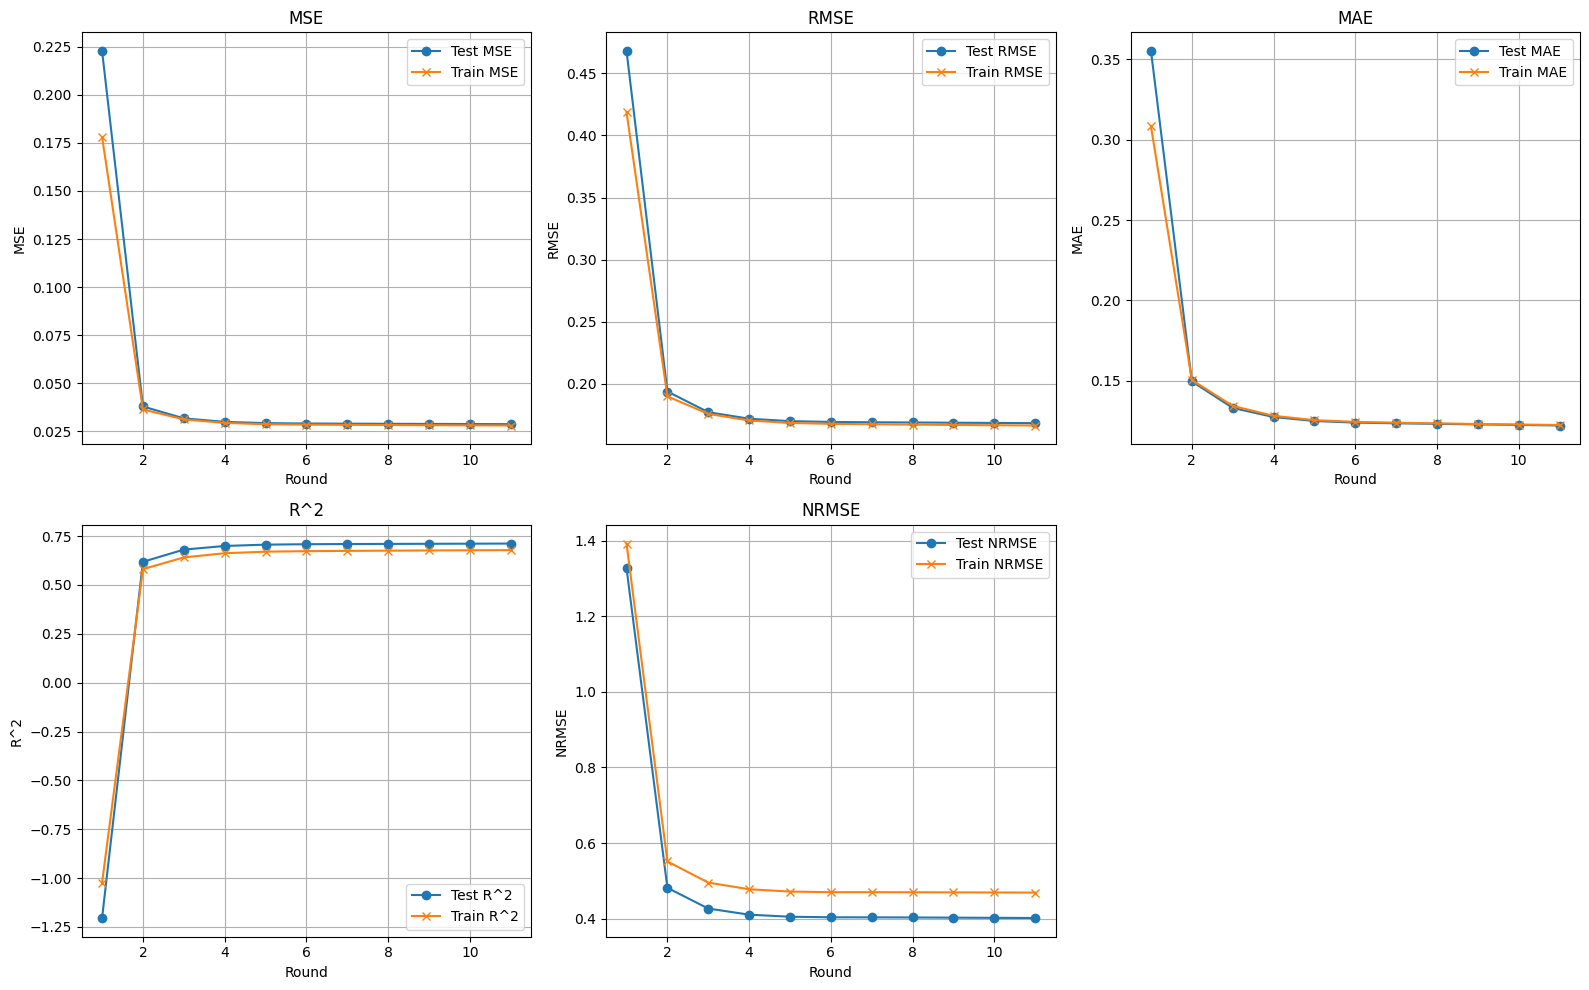

In [38]:
plot_fl_training_metrics(history)

In [39]:
def transform_preds(y_pred_train, y_pred_val):
    if not isinstance(y_pred_train, np.ndarray):
        y_pred_train = y_pred_train.cpu().numpy()
    if not isinstance(y_pred_val, np.ndarray):
        y_pred_val = y_pred_val.cpu().numpy()
    return y_pred_train, y_pred_val

def round_predictions(y_pred_train, y_pred_val, dims):
    # round to closest integer
    if dims is None or len(dims) == 0:
        return y_pred_train, y_pred_val
    for dim in dims:
        y_pred_train[:, dim] = np.rint(y_pred_train[:, dim])
        y_pred_val[:, dim] = np.rint(y_pred_val[:, dim])
    return y_pred_train, y_pred_val

def inverse_transform(y_train, y_val, y_pred_train, y_pred_val,
                     y_scaler=None, 
                     round_preds=False, dims=None):
    y_pred_train, y_pred_val = transform_preds(y_pred_train, y_pred_val)
    
    if y_scaler is not None:
        y_train = y_scaler.inverse_transform(y_train)
        y_val = y_scaler.inverse_transform(y_val)
        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_val = y_scaler.inverse_transform(y_pred_val)
    
    # to zeroes
    y_pred_train[y_pred_train < 0.] = 0.
    y_pred_val[y_pred_val < 0.] = 0.
    
    if round_preds:
        y_pred_train, y_pred_val = round_predictions(y_pred_train, y_pred_val, dims)
    
    return y_train, y_val, y_pred_train, y_pred_val

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

def make_plot_combined(y_true, y_pred, title, feature_names=None, client=None, time_index=None):
    assert y_true.shape == y_pred.shape, f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}"

    if feature_names is None:
        feature_names = [f"t+{i+1}" for i in range(y_pred.shape[1])]
    assert len(feature_names) == y_pred.shape[1]

    # prepare x-axis
    if time_index is not None:
        x = pd.to_datetime(time_index)
    else:
        x = np.arange(y_pred.shape[0])

    for i in range(y_pred.shape[1]):
        plt.figure(figsize=(10, 5))
        plt.ticklabel_format(style='plain')

        plt.plot(x, y_true[:, i], label=f"Actual {feature_names[i]}", linestyle='--')
        plt.plot(x, y_pred[:, i], label=f"Predicted {feature_names[i]}")

        # title
        full_title = f"[{client}] {title} - {feature_names[i]}" if client else f"{title} - {feature_names[i]}"
        plt.title(full_title)

        # axis formatting
        if time_index is not None:
            plt.xlabel("Time")
            ax = plt.gca()
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            plt.gcf().autofmt_xdate()
        else:
            plt.xlabel("Time Step")

        plt.ylabel("Power Output (kW)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [41]:
def inference(
    model, # the global model
    client_X_train, # train data per client
    client_y_train,
    client_X_val, # val data per client
    client_y_val,
    exogenous_data_train, # exogenous data per client
    exogenous_data_val,
    y_scalers, # the scalers used to transform the targets
    idxs=[1],
    apply_round=True, # round to closest integer
    round_dimensions=[0], # the dimensions to apply rounding
    plot=True, # plot predictions
    plot_clients: list = None,  # specify clients to plot, e.g. ['GSRN_001', 'GSRN_002']
    max_plot_clients: int = 5,
    client_time_val_index=None # time index per client for plotting
):
    # load per client data to torch
    train_loaders, val_loaders = [], []
    
    # get data per client
    for client in client_X_train:
        if client == "all":
            continue
        assert client in list(y_scalers.keys())
        if exogenous_data_train is not None:
            tmp_exogenous_data_train = exogenous_data_train[client]
            tmp_exogenous_data_val = exogenous_data_val[client]
        else:
            tmp_exogenous_data_train = None
            tmp_exogenous_data_val = None
    
        num_features = len(client_X_train[client][0][0])
        
        # to torch loader
        train_loaders.append(
            to_torch_dataset(
                client_X_train[client], client_y_train[client],
                num_lags=args.num_lags,
                num_features=num_features,
                exogenous_data=tmp_exogenous_data_train,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
        )
        val_loaders.append(
            to_torch_dataset(
                client_X_val[client], client_y_val[client],
                num_lags=args.num_lags,
                exogenous_data=tmp_exogenous_data_val,
                indices=idxs,
                batch_size=1,
                shuffle=False
            )
            
        )
        
    # get client ids
    cids = [k for k in client_X_train.keys() if k != "all"]
    cids = cids[:max_plot_clients] # limit the number of clients to plot
        
    # predict per client using the global model
    y_preds_train, y_preds_val = dict(), dict()
    for cid, train_loader, val_loader in zip(cids, train_loaders, val_loaders):
        print(f"Prediction on {cid}")
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, y_pred_train = test(
            model, train_loader, None, device=device
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, y_pred_val = test(
            model, val_loader, None, device=device
        )
        y_preds_train[cid] = y_pred_train
        y_preds_val[cid] = y_pred_val
    
    for cid in cids:
        y_train, y_val = client_y_train[cid], client_y_val[cid]
        y_pred_train, y_pred_val = y_preds_train[cid], y_preds_val[cid]
        print(client_y_val[cid][:3])  # print first 3 for checking
        
        y_scaler = y_scalers[cid]
        y_train, y_val, y_pred_train, y_pred_val = inverse_transform(
            y_train, y_val, y_pred_train, y_pred_val,
            y_scaler, round_preds=apply_round, dims=round_dimensions
        )
        train_mse, train_rmse, train_mae, train_r2, train_nrmse, train_res_per_dim, sse_train, sst_train = accumulate_metric(
            y_train, y_pred_train, True, return_all=True, return_sse_sst=True
        )
        val_mse, val_rmse, val_mae, val_r2, val_nrmse, val_res_per_dim, sse_val, sst_val = accumulate_metric(
            y_val, y_pred_val, True, return_all=True, return_sse_sst=True
        )
        print(f"\nFinal Prediction on {cid} (Inference Stage)")
        print(f"[Train]: mse: {train_mse}, "
              f"rmse: {train_rmse}, mae {train_mae}, r2: {train_r2}, nrmse: {train_nrmse}, sse: {sse_train}, sst: {sst_train}")
        print(f"[Val]: mse: {val_mse}, "
              f"rmse: {val_rmse}, mae {val_mae}, r2: {val_r2}, nrmse: {val_nrmse}, sse: {sse_val}, sst: {sst_val}\n\n")

        if plot:
            if (plot_clients is not None and cid not in plot_clients):
                continue
            if plot_clients is None and cids.index(cid) >= max_plot_clients:
                continue

        train_valid_len = len(client_time_train_index[cid])
        val_valid_len = len(client_time_val_index[cid])

        make_plot_combined(
            y_train[-train_valid_len:], 
            y_pred_train[-train_valid_len:], 
            title="Train", 
            feature_names=["t+1", "t+2", "t+3"], 
            client=cid, 
            time_index=client_time_train_index[cid][-train_valid_len:]
        )

        make_plot_combined(
            y_val[-val_valid_len:], 
            y_pred_val[-val_valid_len:], 
            title="Val", 
            feature_names=["t+1", "t+2", "t+3"], 
            client=cid, 
            time_index=client_time_val_index[cid][-val_valid_len:]
        )

Prediction on 570715000000084607
Prediction on 570715000000084652
Prediction on 570715000000088643
Prediction on 570715000000088667
Prediction on 570715000000088810


INFO logger 2025-11-13 17:02:37,782 | helpers.py:60 | Metrics for dimension: 0
	mse: 96581.421875, rmse: 310.7755168525989, mae: 227.5615997314453, r^2: 0.8022351264953613, nrmse: 0.46091872453689575
INFO logger 2025-11-13 17:02:37,784 | helpers.py:60 | Metrics for dimension: 1
	mse: 131973.34375, rmse: 363.2813561827802, mae: 267.0544128417969, r^2: 0.729762852191925, nrmse: 0.5388458967208862
INFO logger 2025-11-13 17:02:37,786 | helpers.py:60 | Metrics for dimension: 2
	mse: 167251.75, rmse: 408.9642404905348, mae: 300.1602478027344, r^2: 0.6572664380073547, nrmse: 0.6068342924118042
INFO logger 2025-11-13 17:02:37,788 | helpers.py:60 | Metrics for dimension: 0
	mse: 94329.0625, rmse: 307.1303672709685, mae: 221.92190551757812, r^2: 0.8229355812072754, nrmse: 0.40366658568382263
INFO logger 2025-11-13 17:02:37,789 | helpers.py:60 | Metrics for dimension: 1
	mse: 133289.640625, rmse: 365.0885380630293, mae: 266.5269775390625, r^2: 0.7498037815093994, nrmse: 0.4798426628112793
INFO lo

[[0.00082944 0.01248527 0.03701925]
 [0.01248527 0.03701925 0.07639586]
 [0.03701925 0.07639586 0.02204566]]

Final Prediction on 570715000000084607 (Inference Stage)
[Train]: mse: 131935.578125, rmse: 363.22937398426353, mae 264.9254455566406, r2: 0.7297547459602356, nrmse: 0.46091872453689575, sse: 555.2453002929688, sst: 1994.5511474609375
[Val]: mse: 134922.3125, rmse: 367.31772690682925, mae 264.6877746582031, r2: 0.7467439770698547, nrmse: 0.40366658568382263, sse: 147.88302612304688, sst: 580.19384765625




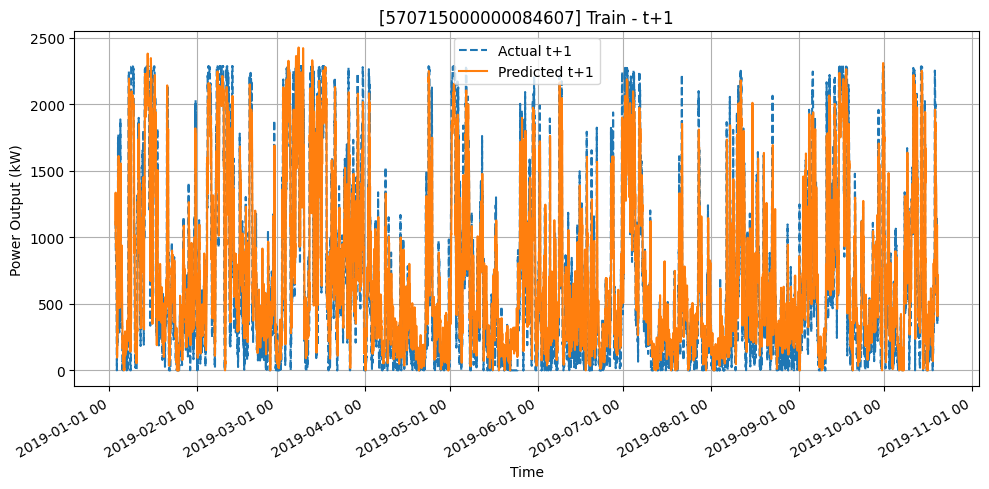

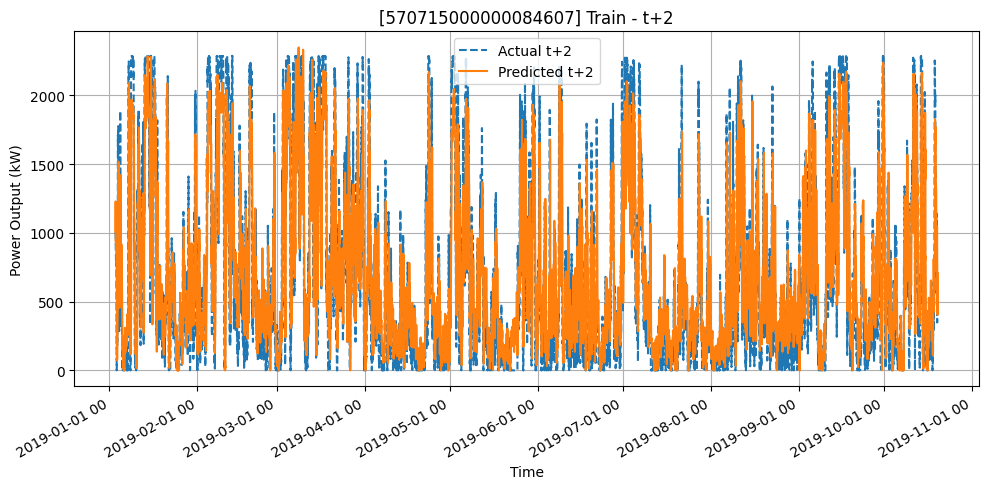

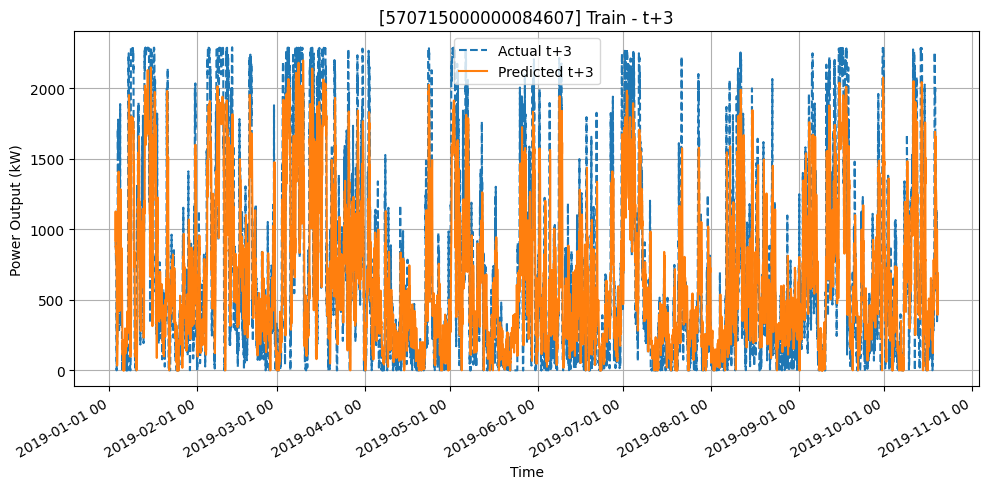

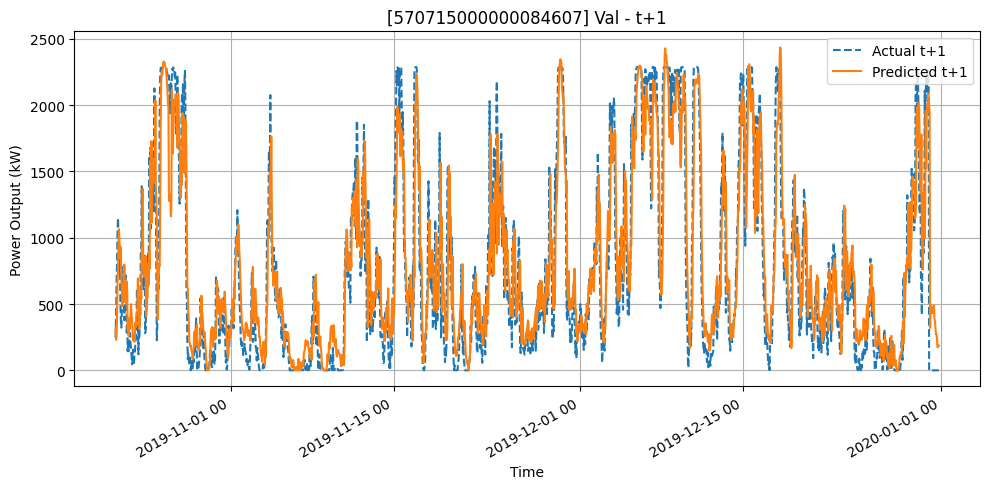

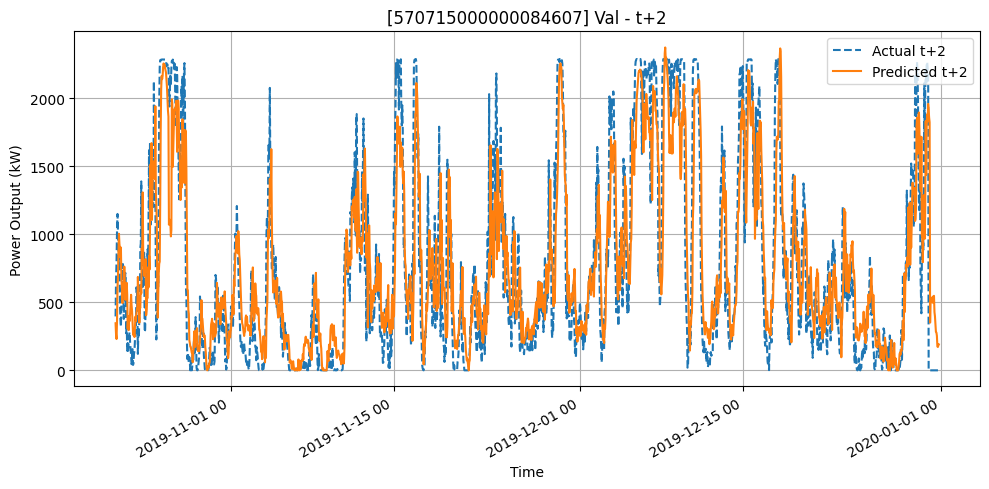

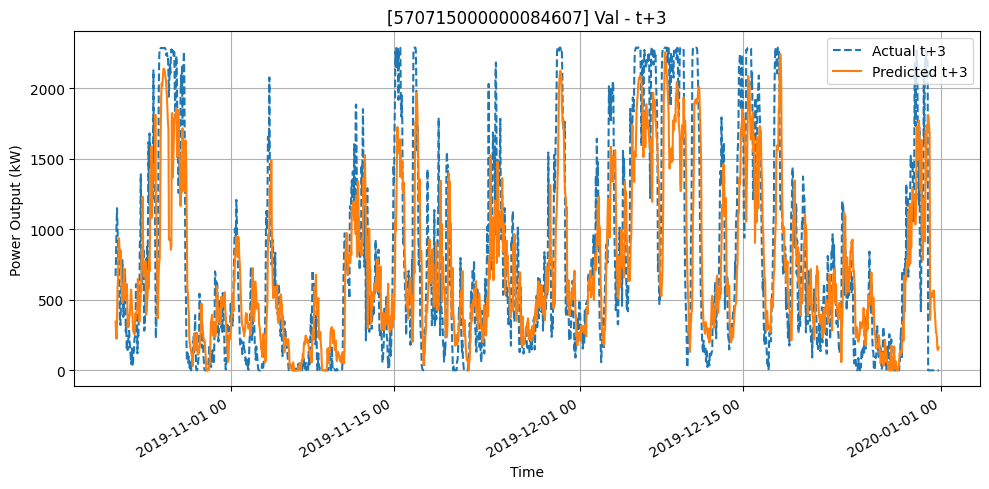

INFO logger 2025-11-13 17:02:39,008 | helpers.py:60 | Metrics for dimension: 0
	mse: 111987.171875, rmse: 334.64484438729966, mae: 241.9550323486328, r^2: 0.7644377946853638, nrmse: 0.5006117224693298
INFO logger 2025-11-13 17:02:39,010 | helpers.py:60 | Metrics for dimension: 1
	mse: 148101.390625, rmse: 384.8394348621253, mae: 282.0611572265625, r^2: 0.688408374786377, nrmse: 0.5758233070373535
INFO logger 2025-11-13 17:02:39,012 | helpers.py:60 | Metrics for dimension: 2
	mse: 183246.546875, rmse: 428.0730625430663, mae: 314.1872253417969, r^2: 0.6141645908355713, nrmse: 0.6407493352890015
INFO logger 2025-11-13 17:02:39,014 | helpers.py:60 | Metrics for dimension: 0
	mse: 98362.046875, rmse: 313.6272419210423, mae: 231.50576782226562, r^2: 0.8234369158744812, nrmse: 0.3870854377746582
INFO logger 2025-11-13 17:02:39,015 | helpers.py:60 | Metrics for dimension: 1
	mse: 141515.671875, rmse: 376.1856880252092, mae: 279.5035705566406, r^2: 0.7459747791290283, nrmse: 0.4642965495586395


[[0.         0.         0.01182735]
 [0.         0.01182735 0.08300964]
 [0.01182735 0.08300964 0.03264522]]

Final Prediction on 570715000000084652 (Inference Stage)
[Train]: mse: 147778.390625, rmse: 384.41955026377104, mae 279.4009094238281, r2: 0.6890035271644592, nrmse: 0.5006117224693298, sse: 555.2453002929688, sst: 1994.5511474609375
[Val]: mse: 143080.453125, rmse: 378.259769371526, mae 277.3772888183594, r2: 0.7431659698486328, nrmse: 0.3870854377746582, sse: 147.88302612304688, sst: 580.19384765625




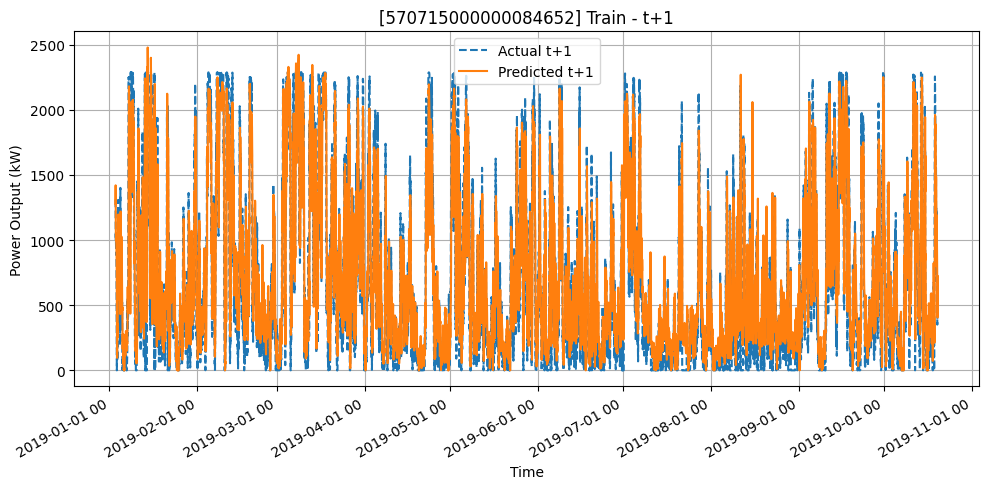

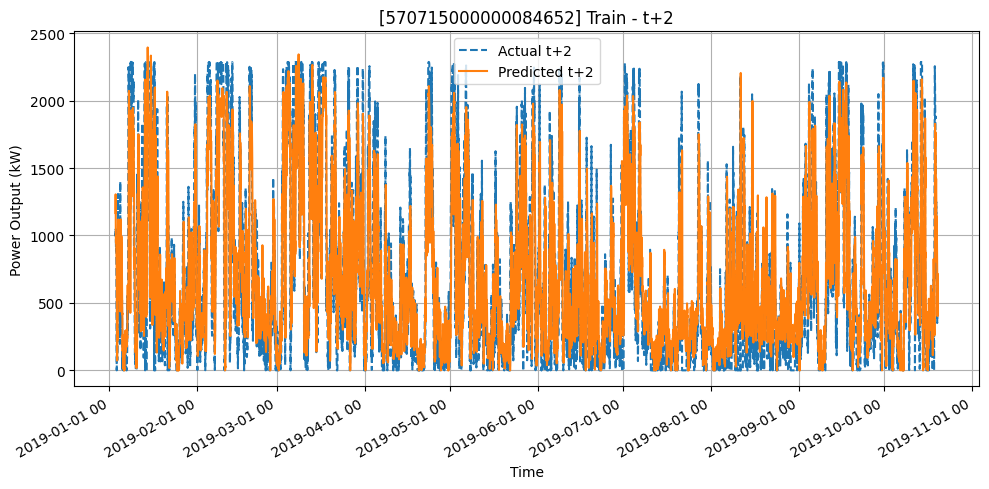

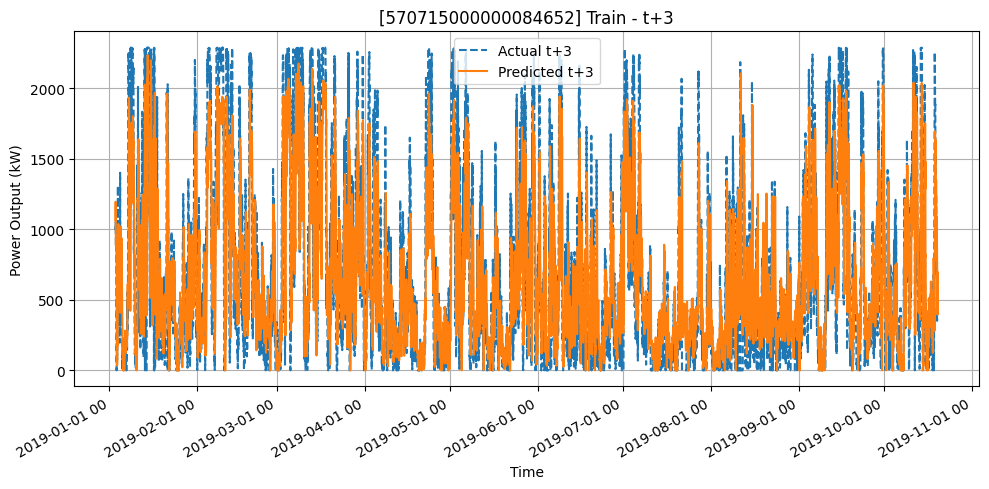

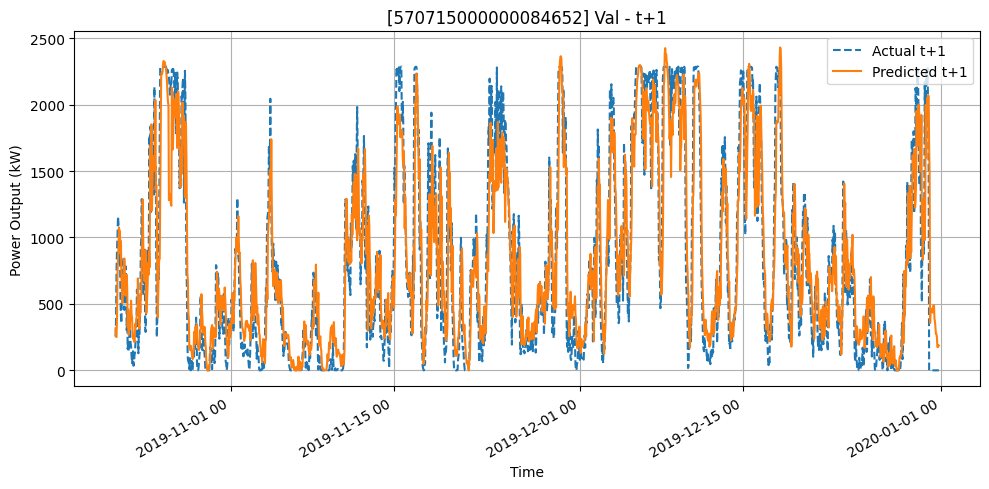

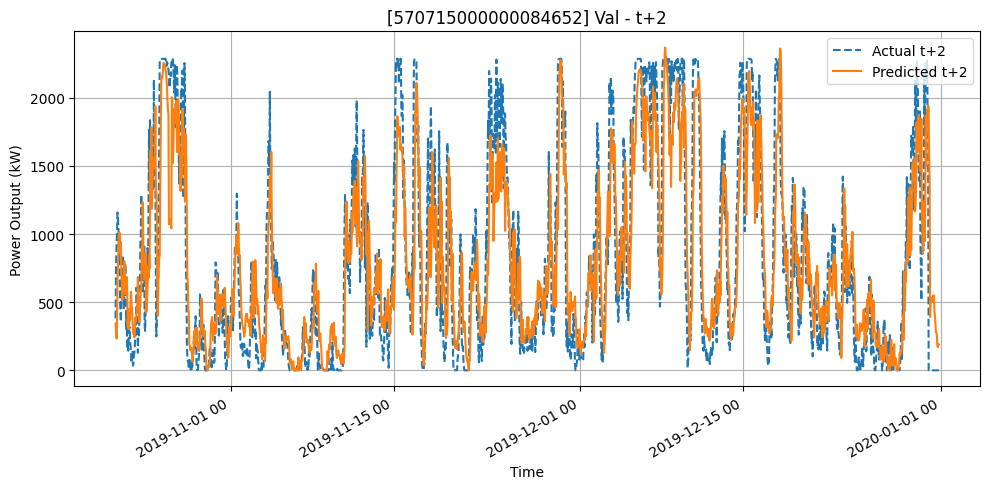

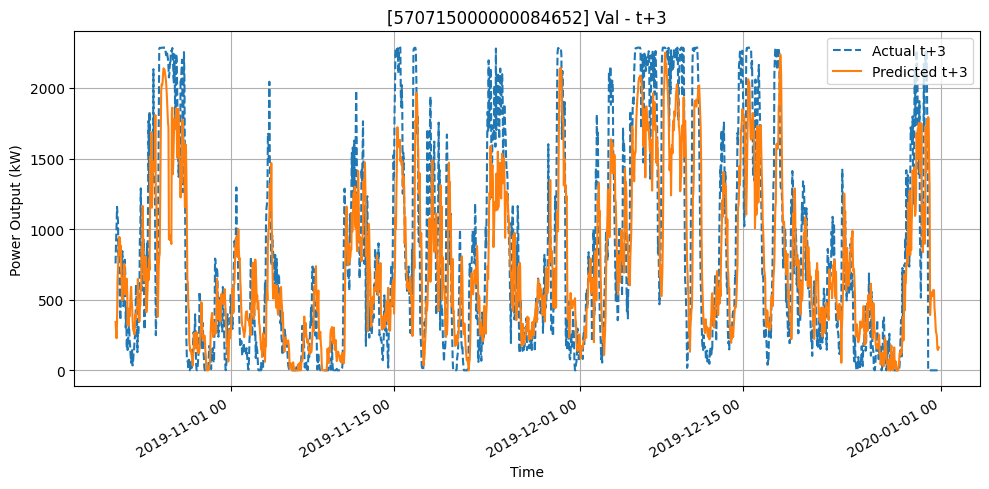

INFO logger 2025-11-13 17:02:40,101 | helpers.py:60 | Metrics for dimension: 0
	mse: 147430.046875, rmse: 383.96620538141116, mae: 270.3294982910156, r^2: 0.7587147951126099, nrmse: 0.46556195616722107
INFO logger 2025-11-13 17:02:40,102 | helpers.py:60 | Metrics for dimension: 1
	mse: 199503.484375, rmse: 446.65812919390595, mae: 328.04071044921875, r^2: 0.6734887361526489, nrmse: 0.5415775179862976
INFO logger 2025-11-13 17:02:40,104 | helpers.py:60 | Metrics for dimension: 2
	mse: 247784.828125, rmse: 497.7798992777832, mae: 371.55084228515625, r^2: 0.5943033695220947, nrmse: 0.6036523580551147
INFO logger 2025-11-13 17:02:40,106 | helpers.py:60 | Metrics for dimension: 0
	mse: 149132.09375, rmse: 386.17624700387773, mae: 270.8059997558594, r^2: 0.7697730660438538, nrmse: 0.3794502317905426
INFO logger 2025-11-13 17:02:40,107 | helpers.py:60 | Metrics for dimension: 1
	mse: 207121.03125, rmse: 455.10551661125794, mae: 331.67523193359375, r^2: 0.6802699565887451, nrmse: 0.44718745350

[[0.0144859  0.03589501 0.03175221]
 [0.03589501 0.03175221 0.10265251]
 [0.03175221 0.10265251 0.04315186]]

Final Prediction on 570715000000088643 (Inference Stage)
[Train]: mse: 198239.5, rmse: 445.2409460056431, mae 323.3070068359375, r2: 0.6755022406578064, nrmse: 0.46556195616722107, sse: 555.2453002929688, sst: 1994.5511474609375
[Val]: mse: 207476.140625, rmse: 455.4954891379277, mae 328.4960021972656, r2: 0.679736852645874, nrmse: 0.3794502317905426, sse: 147.88302612304688, sst: 580.19384765625




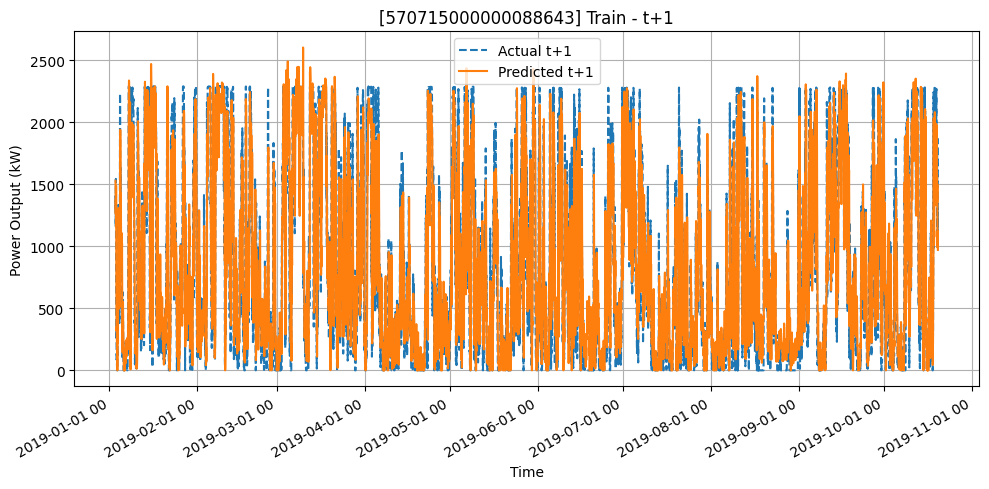

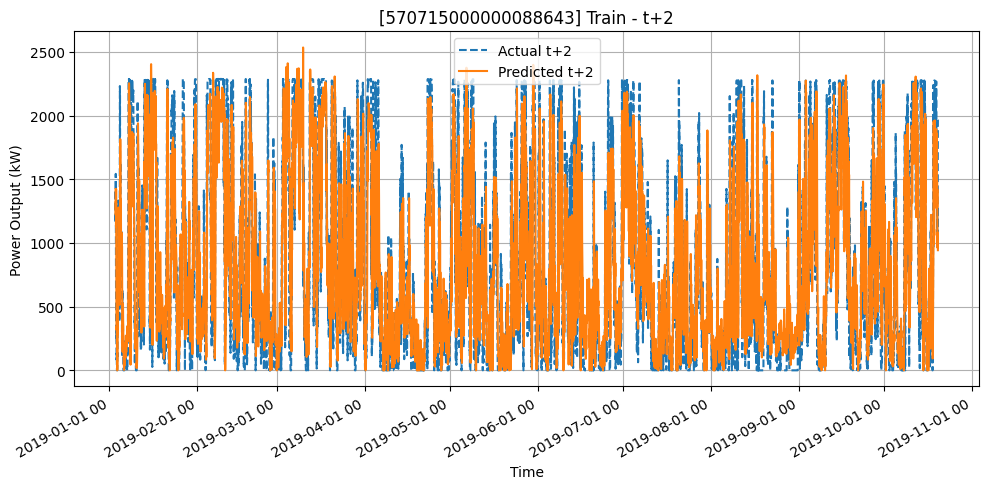

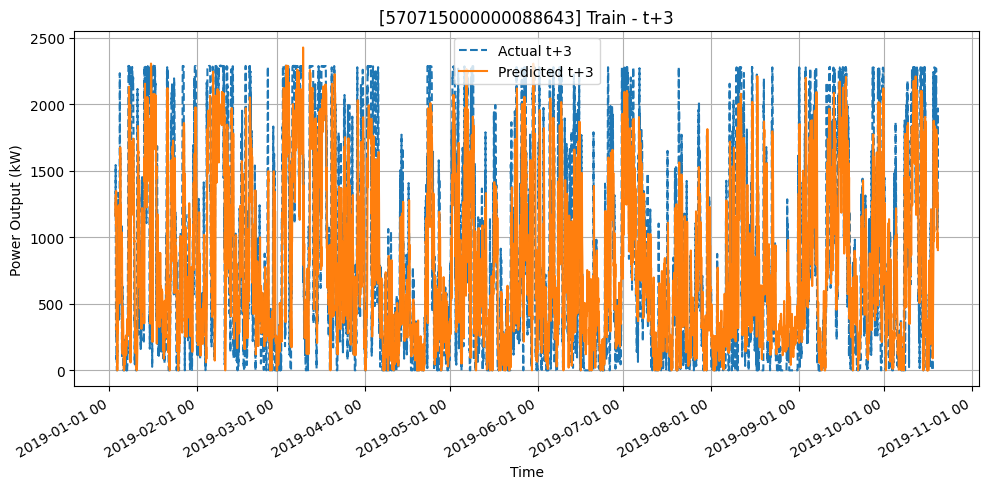

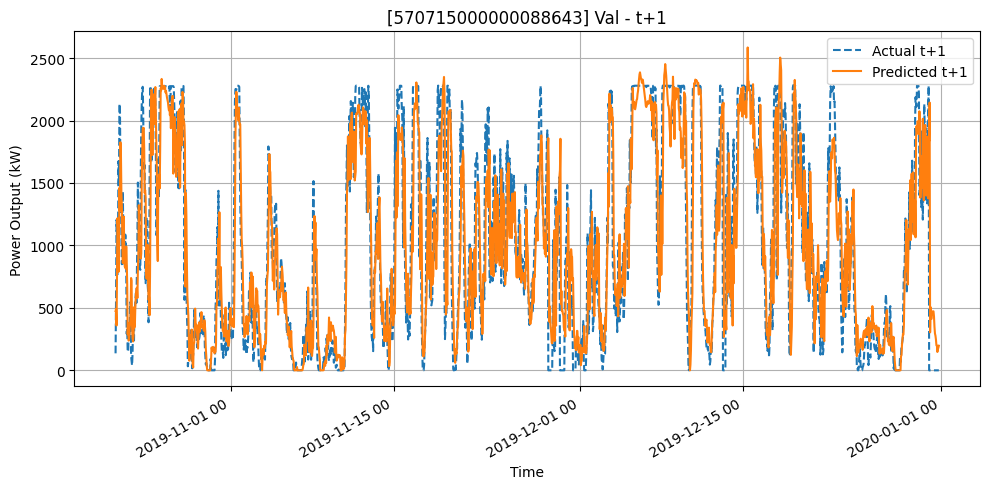

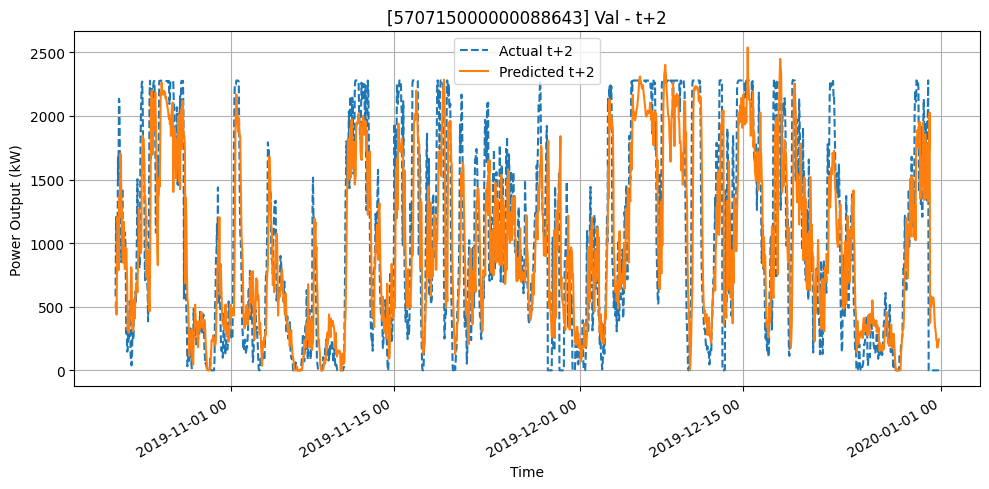

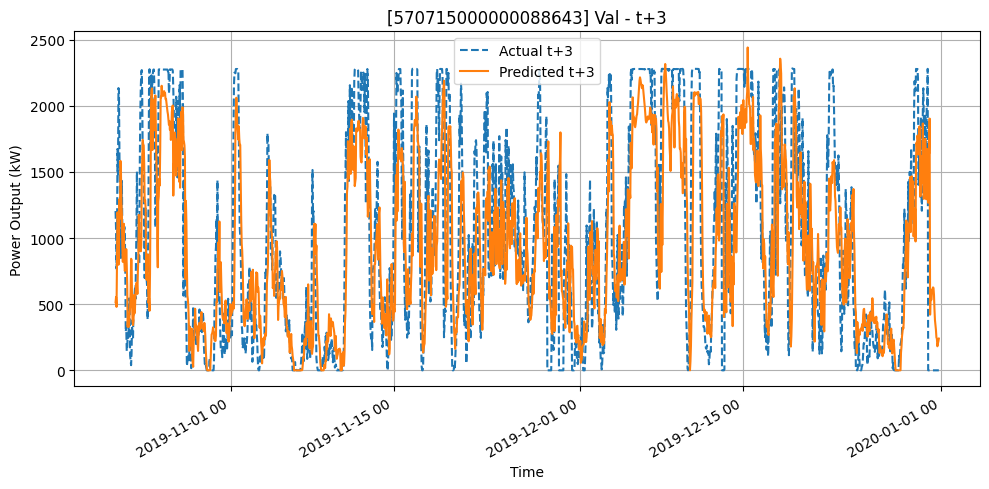

INFO logger 2025-11-13 17:02:41,239 | helpers.py:60 | Metrics for dimension: 0
	mse: 153061.6875, rmse: 391.2309899535056, mae: 269.72216796875, r^2: 0.7245347499847412, nrmse: 0.4770928919315338
INFO logger 2025-11-13 17:02:41,241 | helpers.py:60 | Metrics for dimension: 1
	mse: 206843.390625, rmse: 454.8003854714725, mae: 326.8254699707031, r^2: 0.6277998685836792, nrmse: 0.5544255375862122
INFO logger 2025-11-13 17:02:41,242 | helpers.py:60 | Metrics for dimension: 2
	mse: 251695.25, rmse: 501.6923858302017, mae: 368.3813781738281, r^2: 0.547057569026947, nrmse: 0.6114361882209778
INFO logger 2025-11-13 17:02:41,244 | helpers.py:60 | Metrics for dimension: 0
	mse: 158301.828125, rmse: 397.8716226686694, mae: 273.9195251464844, r^2: 0.7472026348114014, nrmse: 0.3983796238899231
INFO logger 2025-11-13 17:02:41,245 | helpers.py:60 | Metrics for dimension: 1
	mse: 224953.875, rmse: 474.2930265142004, mae: 336.518310546875, r^2: 0.6407814025878906, nrmse: 0.47490599751472473
INFO logger 

[[0.01165724 0.03348469 0.02628854]
 [0.03348469 0.02628854 0.09017766]
 [0.02628854 0.09017766 0.0416899 ]]

Final Prediction on 570715000000088667 (Inference Stage)
[Train]: mse: 203866.6875, rmse: 451.51598808901554, mae 321.6431884765625, r2: 0.6331308484077454, nrmse: 0.4770928919315338, sse: 555.2453002929688, sst: 1994.5511474609375
[Val]: mse: 223814.0, rmse: 473.0898434758455, mae 333.4555969238281, r2: 0.6426183581352234, nrmse: 0.3983796238899231, sse: 147.88302612304688, sst: 580.19384765625




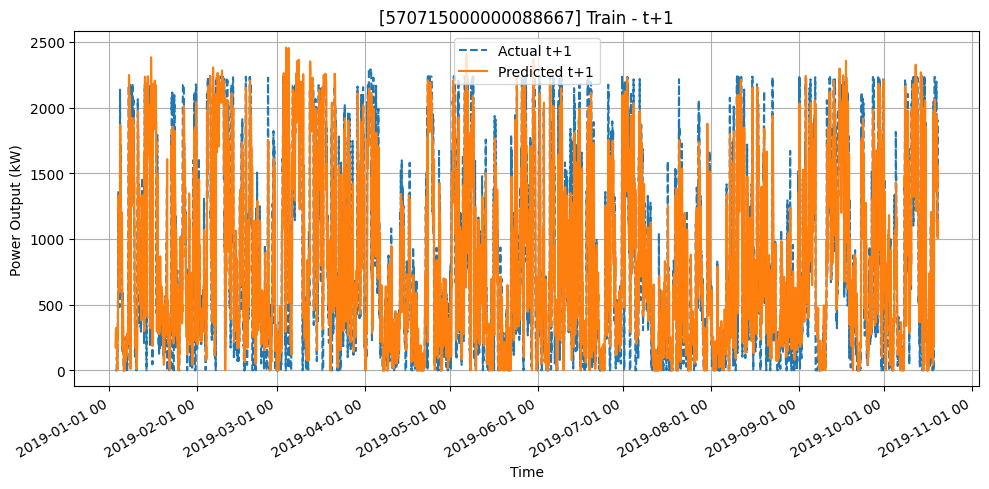

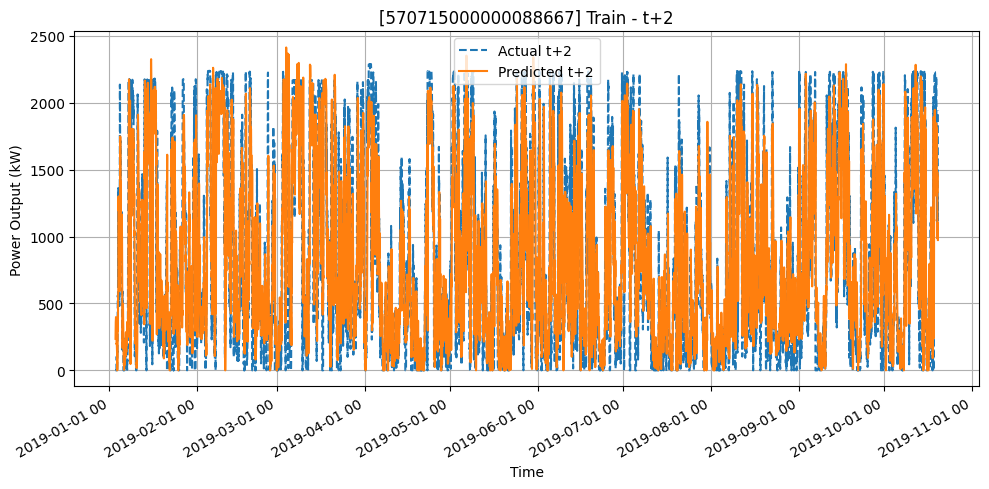

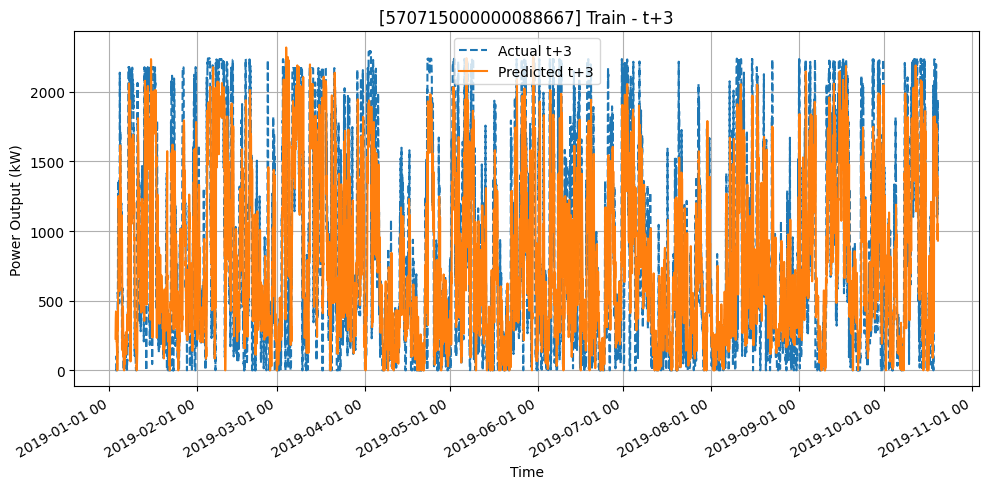

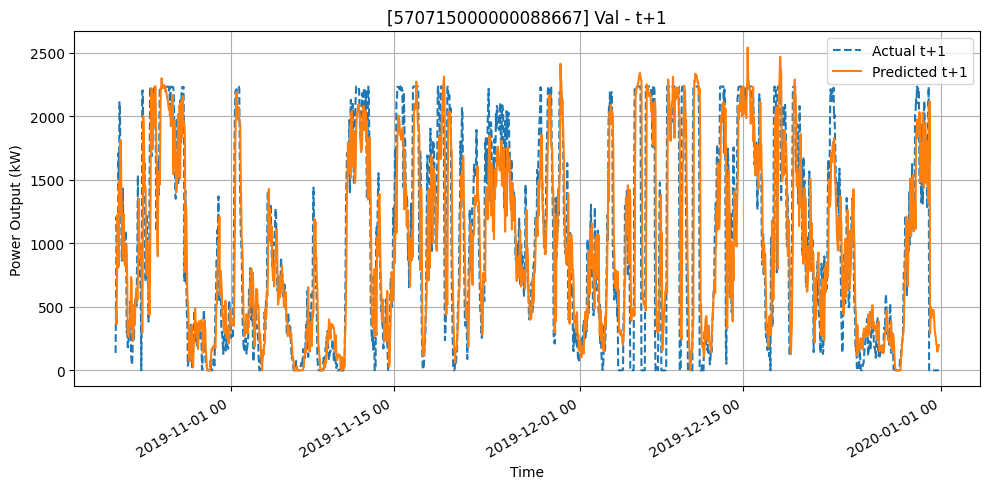

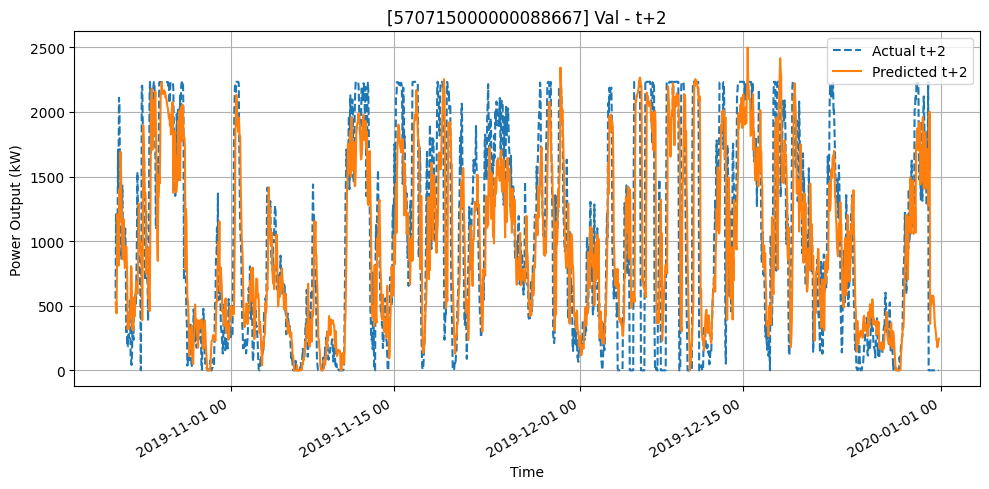

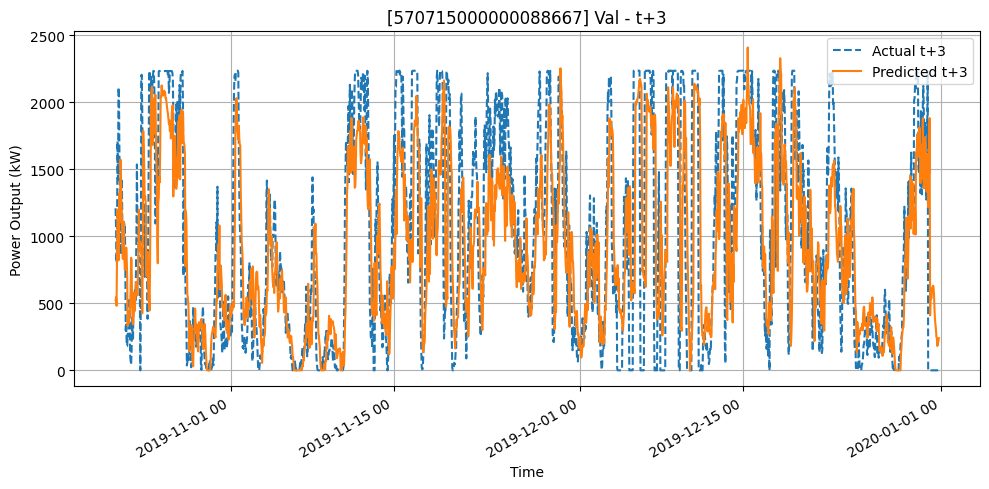

INFO logger 2025-11-13 17:02:42,764 | helpers.py:60 | Metrics for dimension: 0
	mse: 101573.84375, rmse: 318.7065166418785, mae: 234.3654022216797, r^2: 0.7964156866073608, nrmse: 0.41313254833221436
INFO logger 2025-11-13 17:02:42,766 | helpers.py:60 | Metrics for dimension: 1
	mse: 138648.53125, rmse: 372.35538300123983, mae: 278.1731262207031, r^2: 0.7219256162643433, nrmse: 0.48282238841056824
INFO logger 2025-11-13 17:02:42,768 | helpers.py:60 | Metrics for dimension: 2
	mse: 176003.765625, rmse: 419.5280272222584, mae: 314.6178283691406, r^2: 0.6467801928520203, nrmse: 0.5441673398017883
INFO logger 2025-11-13 17:02:42,770 | helpers.py:60 | Metrics for dimension: 0
	mse: 101994.9609375, rmse: 319.3664993976356, mae: 231.6043243408203, r^2: 0.8262011408805847, nrmse: 0.37158429622650146
INFO logger 2025-11-13 17:02:42,772 | helpers.py:60 | Metrics for dimension: 1
	mse: 148550.84375, rmse: 385.42294139036403, mae: 279.64453125, r^2: 0.7469030618667603, nrmse: 0.448465496301651
INF

[[0.03505326 0.08717478 0.13287933]
 [0.08717478 0.13287933 0.125502  ]
 [0.13287933 0.125502   0.09900471]]

Final Prediction on 570715000000088810 (Inference Stage)
[Train]: mse: 138742.171875, rmse: 372.48110270858035, mae 275.718994140625, r2: 0.7217069268226624, nrmse: 0.41313254833221436, sse: 555.2453002929688, sst: 1994.5511474609375
[Val]: mse: 149547.296875, rmse: 386.7134557718415, mae 278.5718688964844, r2: 0.7452314496040344, nrmse: 0.37158429622650146, sse: 147.88302612304688, sst: 580.19384765625




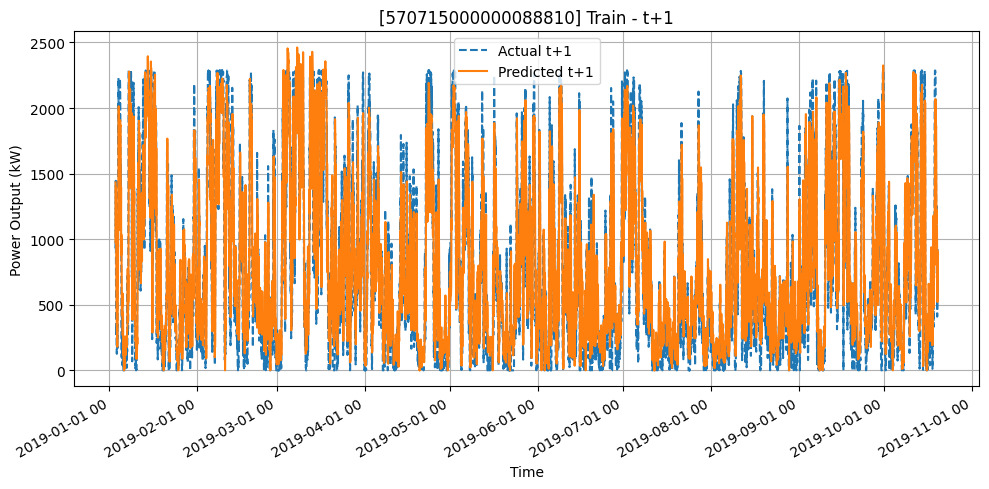

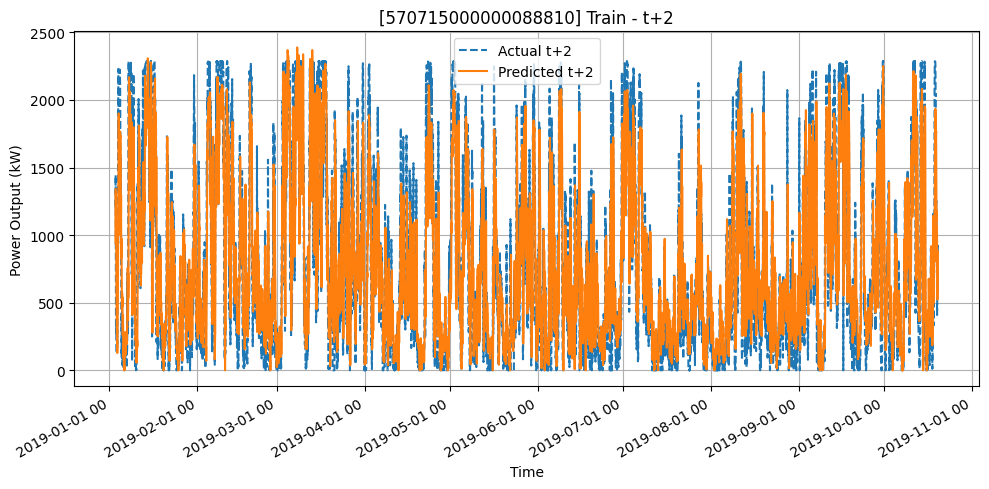

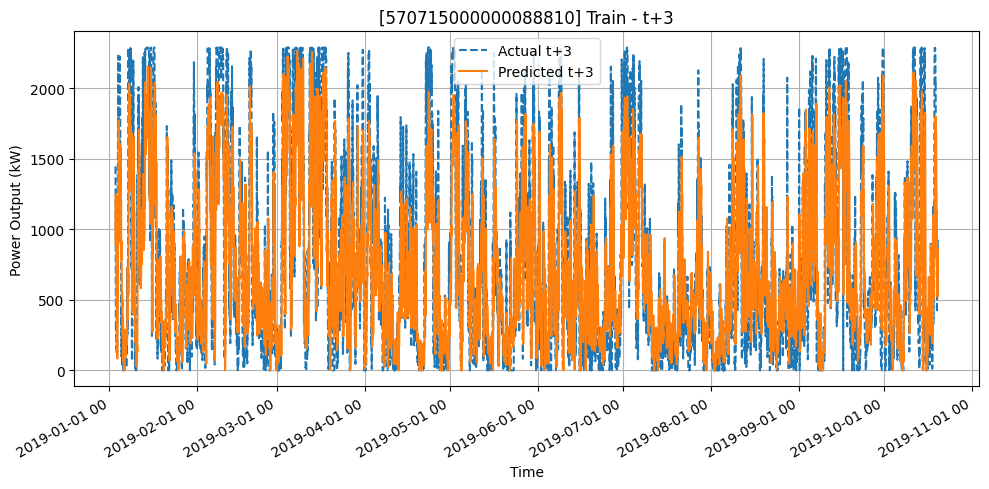

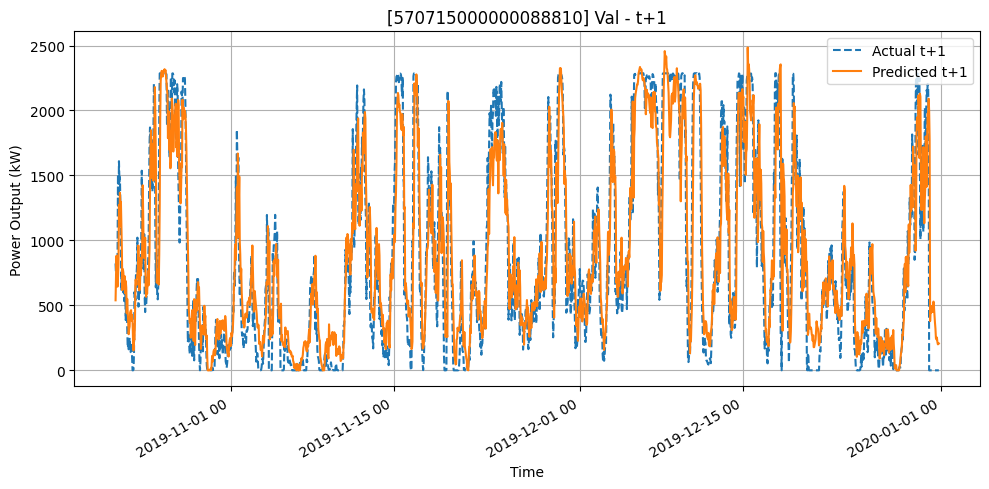

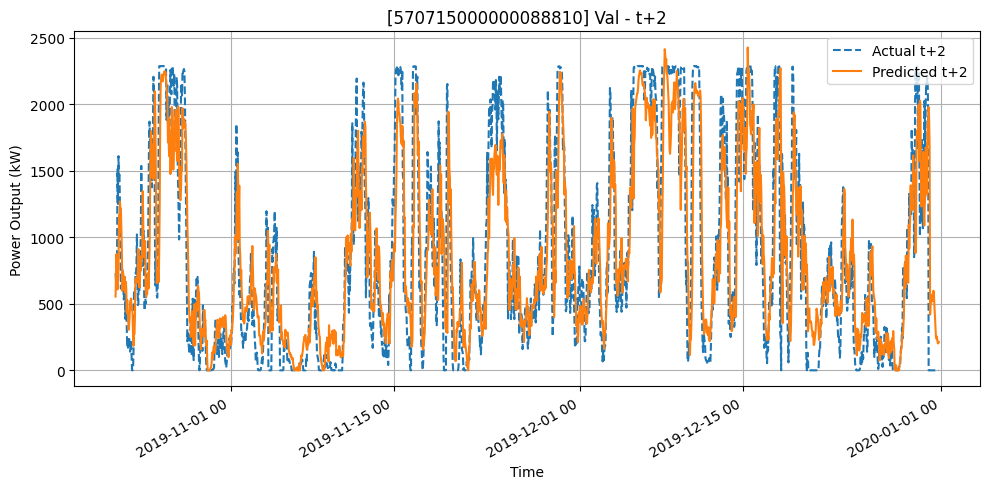

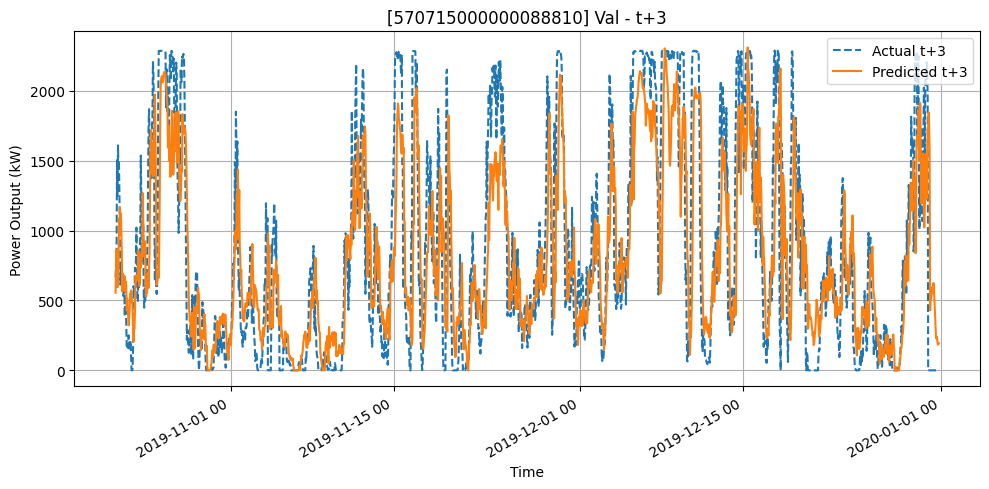

In [42]:
inference(
    global_model,
    client_X_train, 
    client_y_train,
    client_X_val, 
    client_y_val,
    exogenous_data_train, 
    exogenous_data_val,
    y_scalers,
    client_time_val_index=client_time_val_index
)